## **研究主題：探討PTT使用者對於新青安政策的討論與看法**

### 研究動機
隨著年齡增長，我的人生規劃也進一步推進，而購屋成為特別需要關注的一部分。政府在2023年8月推出「青年安心成家貸款精進方案」(簡稱新青安)，引發了許多年輕世代的討論，當我在搜尋相關資訊與心得時，注意到網路上存在許多不同甚至對立的意見，這使我想更深入了解人們如何看待這項政策，以及討論內容背後所反映的不同立場與價值觀。

### 研究背景
- 主要原因：房價飆漲，青年購屋困難  

政府希望減輕青年與首購族的購屋壓力，所以進一步推出此方案。申請條件為年滿18歲，且申請人本人、配偶與未成年子女名下均無自有住宅即可。貸款額度最高可到1000萬、成數最高8成、還款年限最長則至40年，寬限期則有5年，可以選擇「本息平均攤還」或是「本金平均攤還」。另外，如果符合條件，也可以與內政部的「自購住宅貸款利息補貼」併用。  

但是，這個方案上路後引起很多討論，有一部分的人認為這項政策確實能幫助年輕人購屋，像是更容易買到理想中的房子，或提早實現人生規劃；但也有人認為，除了房價可能漲得更快，房市也預期會出現拋售潮。
這些不同聲音讓「新青安」成為熱門話題，也帶動了PTT等網路社群的熱烈討論。

- 參考資料  
    - https://www.nta.gov.tw/singlehtml/109
    - https://www.businessweekly.com.tw/focus/indep/6015399
    - https://www.businessweekly.com.tw/business/blog/3016446

### 研究問題
- 民眾討論新青安時，整體情緒是偏正向還是負向？
- 在正面與負面意見中，常出現主題或議題有哪些？
- 如果時間上有變化趨勢，又可能跟哪些議題相關？

### 大綱
1. 資料前處理
2. Lecicon-base情緒分析

In [1]:
import pandas as pd
import re
import jieba
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import time
from snownlp import SnowNLP
import math
from tqdm import tqdm
import swifter
from nltk import ngrams
from collections import Counter, namedtuple
from nltk import FreqDist
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import numpy as np
from numpy.linalg import norm

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 讓中文正常顯示
plt.rcParams['axes.unicode_minus'] # 讓負號正常顯示


c:\Users\Shelly\new_anaconda3\envs\loan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
%pwd

'c:\\NSYSU\\analytics_project\\nlp'

### 1. 資料前處理
#### 1.1 基本資料介紹
- 資料來源：PTT抓取Gossiping版
- 抓取時段：2023-08-01 至 2025-08-01
- 關鍵字：新青安、青年安心成家貸款、青安貸款、青年安心成家購屋、青年首購貸款

In [3]:
article = pd.read_csv('./raw_data/articles.csv')
comments = pd.read_csv('./raw_data/comments.csv')

In [4]:
print(f'共有{article.shape[0]}篇文章')
article.head()

共有3094篇文章


title              time  \
0                     [請益] 房貸選擇  2025/09/03 11:34   
1        [新聞] 全台房價 自歷史高點回落0.59％  2025/09/03 11:40   
2         [請益] 關於內政部的自購住宅貸款利息補貼  2025/09/03 13:35   
3  Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎  2025/09/03 16:21   
4  Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭  2025/09/02 17:14   

                                                 url  \
0  https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1  https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2  https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3  https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4  https://www.ptt.cc/bbs/home-sale/M.1756804442....   

                                             content  
0  貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  
1  全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  
2  爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  
3  鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  
4  : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....

In [5]:
print(f'共有{comments.shape[0]}則留言')
comments.head()

共有206322則留言


artTitle                                             artUrl     cmtUser  \
0  [請益] 房貸選擇  https://www.ptt.cc/bbs/home-sale/M.1756870456....       rgbff   
1  [請益] 房貸選擇  https://www.ptt.cc/bbs/home-sale/M.1756870456....      jkduke   
2  [請益] 房貸選擇  https://www.ptt.cc/bbs/home-sale/M.1756870456....  dontpushme   
3  [請益] 房貸選擇  https://www.ptt.cc/bbs/home-sale/M.1756870456....     hypolen   
4  [請益] 房貸選擇  https://www.ptt.cc/bbs/home-sale/M.1756870456....     dirk007   

  cmtTag     cmtContent cmtIP           cmtTime  
0      推    選A然後去金管會檢舉?   NaN  2025/09/03 11:43  
1      推   選B 三年後換個銀行轉貸   NaN  2025/09/03 11:46  
2      推            樓上讚   NaN  2025/09/03 11:46  
3      推          選b檢舉a   NaN  2025/09/03 11:50  
4      推              B   NaN  2025/09/03 11:58

In [6]:
# 確保抓取文章跟關鍵字是一致的
keywords = ['新青安','青年安心成家貸款','青安貸款','青年安心成家購屋','青年首購貸款']
match = '|'.join(keywords)

In [7]:
article = article.loc[article['title'].str.contains(match)|article['content'].str.contains(match), :]
article.reset_index(inplace=True, drop = True)
print(article.shape)

(3094, 4)


#### 1.2 資料清理
- 整理日期的輸出
- 去除NA值
- 去除非中文字詞

In [8]:
article['time'] = pd.to_datetime(article['time'])
article['date'] = article['time'].dt.date
article = article.drop('time',axis=1)
article

title  \
0                                [請益] 房貸選擇   
1                   [新聞] 全台房價 自歷史高點回落0.59％   
2                    [請益] 關於內政部的自購住宅貸款利息補貼   
3             Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎   
4             Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭   
...                                    ...   
3089              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上   
3090             Re: [閒聊] 85年次以後的年輕工程師有多慘？   
3091          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊   
3092               [新聞] 新青安房貸今上路 建商救命浮木來了？   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1     https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2     https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3     https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4     https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                 ...   
3089  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
3090  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
3091  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
3092  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content        date  
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03  
1     全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03  
2     爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  2025-09-03  
3     鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  2025-09-03  
4     : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  2025-09-02  
...                                                 ...         ...  
3089  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  2023-08-01  
3090  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  2023-08-02  
3091  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  2023-08-02  
3092  連結：\nhttps://money.udn.com/money/story/5621/73...  2023-08-01  
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01  

[3094 rows x 4 columns]

In [9]:
comments['cmtTime'] = pd.to_datetime(comments['cmtTime'])
comments['cmtDate'] = comments['cmtTime'].dt.date
comments = comments.drop(columns = ['cmtTime','cmtUser','cmtTag','cmtIP'])
comments

artTitle  \
0                                  [請益] 房貸選擇   
1                                  [請益] 房貸選擇   
2                                  [請益] 房貸選擇   
3                                  [請益] 房貸選擇   
4                                  [請益] 房貸選擇   
...                                      ...   
206317  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206318  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206319  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206320  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206321  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                   artUrl  \
0       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                   ...   
206317  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206318  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206319  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206320  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206321  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                   cmtContent     cmtDate  
0                 選A然後去金管會檢舉?  2025-09-03  
1                選B 三年後換個銀行轉貸  2025-09-03  
2                         樓上讚  2025-09-03  
3                       選b檢舉a  2025-09-03  
4                           B  2025-09-03  
...                       ...         ...  
206317              羨慕  我拿不到了  2023-08-01  
206318   曾幾何時千萬代表豪宅 百萬代表名車 ..  2023-08-01  
206319        放屁 沒救了 房價噴上去很難降  2023-08-01  
206320     認真問，請問滿18歲的學生可以貸嗎？  2023-08-01  
206321                全面救金主嗎？  2023-08-01  

[206322 rows x 4 columns]

In [10]:
# 文章內容正規處理
article['filter_content'] = article.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
article

title  \
0                                [請益] 房貸選擇   
1                   [新聞] 全台房價 自歷史高點回落0.59％   
2                    [請益] 關於內政部的自購住宅貸款利息補貼   
3             Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎   
4             Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭   
...                                    ...   
3089              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上   
3090             Re: [閒聊] 85年次以後的年輕工程師有多慘？   
3091          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊   
3092               [新聞] 新青安房貸今上路 建商救命浮木來了？   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1     https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2     https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3     https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4     https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                 ...   
3089  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
3090  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
3091  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
3092  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content        date  \
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1     全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03   
2     爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  2025-09-03   
3     鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  2025-09-03   
4     : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  2025-09-02   
...                                                 ...         ...   
3089  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  2023-08-01   
3090  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  2023-08-02   
3091  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  2023-08-02   
3092  連結：\nhttps://money.udn.com/money/story/5621/73...  2023-08-01   
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                         filter_content  
0     貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  
1     全台房價自歷史高點回落郭及天台北報導年月日週一上午去年月日央行第七波選擇性信用管制出爐成為這...  
2     爬了許多文還是不太了解希望有大大能幫忙解答這麼說好了目前我已經有申請新青安年寬限期貸款是萬利...  
3     鬆綁怎麼就只鬆管制部份你要回歸市場機制就要完全回歸新青安就不用講什麼首購最大這種鳥觀念也都要...  
4     連結金管會央行邀銀行研議開大房貸水龍頭內文民眾想買房卻貸不到款卓揆日前喊話希望銀行放款水龍頭...  
...                                                 ...  
3089  減輕年輕人買房負擔青安貸款升級版今上路賴清德一張圖報你知連結內文記者盧素梅台北報導青年安心成...  
3090  原文恕刪背景交代一下小弟正好年次前年台大非電資科系碩班畢業上山非產線常日班目前年資剛好兩年家...  
3091  作者奶奶看板標題新聞新青安貸款威力開始了網曝新北預售屋齊時間媒體來源記者署名余奕賢完整新聞標...  
3092  連結內文經濟日報記者游智文即時報導新版青年安心成家優惠房貸專案今日上路元宏不動產加值服務平台...  
3093  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...  

[3094 rows x 5 columns]

In [11]:
# 留言正規處理
comments['filter_cmtContent'] = comments.cmtContent.astype(str).apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
comments = comments[comments['cmtContent'].str.strip() != '']
comments

artTitle  \
0                                  [請益] 房貸選擇   
1                                  [請益] 房貸選擇   
2                                  [請益] 房貸選擇   
3                                  [請益] 房貸選擇   
4                                  [請益] 房貸選擇   
...                                      ...   
206317  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206318  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206319  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206320  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206321  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                   artUrl  \
0       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                   ...   
206317  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206318  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206319  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206320  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206321  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                   cmtContent     cmtDate filter_cmtContent  
0                 選A然後去金管會檢舉?  2025-09-03         選然後去金管會檢舉  
1                選B 三年後換個銀行轉貸  2025-09-03        選三年後換個銀行轉貸  
2                         樓上讚  2025-09-03               樓上讚  
3                       選b檢舉a  2025-09-03               選檢舉  
4                           B  2025-09-03                    
...                       ...         ...               ...  
206317              羨慕  我拿不到了  2023-08-01           羨慕我拿不到了  
206318   曾幾何時千萬代表豪宅 百萬代表名車 ..  2023-08-01  曾幾何時千萬代表豪宅百萬代表名車  
206319        放屁 沒救了 房價噴上去很難降  2023-08-01     放屁沒救了房價噴上去很難降  
206320     認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎  
206321                全面救金主嗎？  2023-08-01            全面救金主嗎  

[206322 rows x 5 columns]

#### 1.3 斷詞與移除停用字
- 設定中文詞庫
- 斷詞使用Jieba

**文章部分**

In [10]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
# 設定自定義詞庫
jieba.load_userdict('./dict/user_dict.txt')

# 停用字
with open('./dict/stopwords.txt', encoding='utf-8') as f:
    stopwords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\NSYSU\analytics_project\nlp\dict\dict.txt.big ...
Loading model from cache C:\Users\Shelly\AppData\Local\Temp\jieba.u0f7b98df0d0af54dc1d176608c9315c1.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


In [13]:
# 針對文章內容進行斷詞
article_token = article.assign(word=article['filter_content'].apply(lambda x: jieba.lcut(x))).explode('word').reset_index(drop=True)


In [14]:
article_token

title  \
0                                   [請益] 房貸選擇   
1                                   [請益] 房貸選擇   
2                                   [請益] 房貸選擇   
3                                   [請益] 房貸選擇   
4                                   [請益] 房貸選擇   
...                                       ...   
1120528  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120529  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120530  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120531  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120532  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                       url  \
0        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                    ...   
1120528  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120529  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120530  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120531  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120532  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                   content        date  \
0        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
4        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                    ...         ...   
1120528  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120529  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120530  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120531  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120532  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                            filter_content word  
0        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   貸款  
1        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   選擇  
2        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   請益  
3        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行  
4        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    成  
...                                                    ...  ...  
1120528  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   上車  
1120529  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    的  
1120530  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   乘客  
1120531  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    請  
1120532  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   盡快  

[1120533 rows x 6 columns]

In [15]:
article_token = article_token.loc[article_token['word'].str.len()>1]
article_token

title  \
0                                   [請益] 房貸選擇   
1                                   [請益] 房貸選擇   
2                                   [請益] 房貸選擇   
3                                   [請益] 房貸選擇   
5                                   [請益] 房貸選擇   
...                                       ...   
1120525  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120527  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120528  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120530  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120532  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                       url  \
0        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
5        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                    ...   
1120525  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120527  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120528  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120530  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120532  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                   content        date  \
0        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
5        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                    ...         ...   
1120525  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120527  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120528  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120530  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120532  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                            filter_content word  
0        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   貸款  
1        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   選擇  
2        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   請益  
3        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行  
5        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安  
...                                                    ...  ...  
1120525  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   啟動  
1120527  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   還沒  
1120528  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   上車  
1120530  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   乘客  
1120532  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   盡快  

[732691 rows x 6 columns]

In [16]:
with open('./dict/stopwords.txt',encoding = 'utf-8') as f:
    stopwords = [line.strip() for line in f.readlines()]

article_token = article_token.loc[~article_token['word'].isin(stopwords)]
article_token

title  \
0                                   [請益] 房貸選擇   
1                                   [請益] 房貸選擇   
2                                   [請益] 房貸選擇   
3                                   [請益] 房貸選擇   
5                                   [請益] 房貸選擇   
...                                       ...   
1120525  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120527  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120528  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120530  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120532  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                       url  \
0        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
5        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                    ...   
1120525  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120527  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120528  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120530  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120532  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                   content        date  \
0        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
5        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                    ...         ...   
1120525  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120527  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120528  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120530  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120532  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                            filter_content word  
0        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   貸款  
1        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   選擇  
2        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   請益  
3        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行  
5        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安  
...                                                    ...  ...  
1120525  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   啟動  
1120527  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   還沒  
1120528  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   上車  
1120530  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   乘客  
1120532  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   盡快  

[618162 rows x 6 columns]

In [17]:
# article_token.to_csv('./filter/article_token.csv')

**留言部分**

In [18]:
# 針對留言進行斷詞
comment_token = comments.assign(word=comments['filter_cmtContent'].astype(str).apply(lambda x: jieba.lcut(x))).explode('word').reset_index(drop=True)
comment_token = comment_token.loc[comment_token['word'].str.len()>1]
comment_token

artTitle  \
1                                   [請益] 房貸選擇   
3                                   [請益] 房貸選擇   
4                                   [請益] 房貸選擇   
6                                   [請益] 房貸選擇   
8                                   [請益] 房貸選擇   
...                                       ...   
1800851  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800853  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800854  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800857  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800859  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                    artUrl  \
1        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
6        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
8        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                    ...   
1800851  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800853  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800854  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800857  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800859  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                  cmtContent     cmtDate filter_cmtContent word  
1                選A然後去金管會檢舉?  2025-09-03         選然後去金管會檢舉   然後  
3                選A然後去金管會檢舉?  2025-09-03         選然後去金管會檢舉  金管會  
4                選A然後去金管會檢舉?  2025-09-03         選然後去金管會檢舉   檢舉  
6               選B 三年後換個銀行轉貸  2025-09-03        選三年後換個銀行轉貸   三年  
8               選B 三年後換個銀行轉貸  2025-09-03        選三年後換個銀行轉貸   換個  
...                      ...         ...               ...  ...  
1800851   認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎   滿歲  
1800853   認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎   學生  
1800854   認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎   可以  
1800857              全面救金主嗎？  2023-08-01            全面救金主嗎   全面  
1800859              全面救金主嗎？  2023-08-01            全面救金主嗎   金主  

[1043305 rows x 6 columns]

In [19]:
comments

artTitle  \
0                                  [請益] 房貸選擇   
1                                  [請益] 房貸選擇   
2                                  [請益] 房貸選擇   
3                                  [請益] 房貸選擇   
4                                  [請益] 房貸選擇   
...                                      ...   
206317  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206318  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206319  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206320  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
206321  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                   artUrl  \
0       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                   ...   
206317  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206318  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206319  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206320  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
206321  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                   cmtContent     cmtDate filter_cmtContent  
0                 選A然後去金管會檢舉?  2025-09-03         選然後去金管會檢舉  
1                選B 三年後換個銀行轉貸  2025-09-03        選三年後換個銀行轉貸  
2                         樓上讚  2025-09-03               樓上讚  
3                       選b檢舉a  2025-09-03               選檢舉  
4                           B  2025-09-03                    
...                       ...         ...               ...  
206317              羨慕  我拿不到了  2023-08-01           羨慕我拿不到了  
206318   曾幾何時千萬代表豪宅 百萬代表名車 ..  2023-08-01  曾幾何時千萬代表豪宅百萬代表名車  
206319        放屁 沒救了 房價噴上去很難降  2023-08-01     放屁沒救了房價噴上去很難降  
206320     認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎  
206321                全面救金主嗎？  2023-08-01            全面救金主嗎  

[206322 rows x 5 columns]

In [20]:
with open('./dict/stopwords.txt',encoding = 'utf-8') as f:
    stopwords = [line.strip() for line in f.readlines()]

comment_token = comment_token.loc[~comment_token['word'].isin(stopwords)]
comment_token

artTitle  \
3                                   [請益] 房貸選擇   
4                                   [請益] 房貸選擇   
6                                   [請益] 房貸選擇   
8                                   [請益] 房貸選擇   
9                                   [請益] 房貸選擇   
...                                       ...   
1800850  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800851  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800853  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800857  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1800859  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                    artUrl  \
3        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
6        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
8        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
9        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                    ...   
1800850  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800851  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800853  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800857  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1800859  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                  cmtContent     cmtDate filter_cmtContent word  
3                選A然後去金管會檢舉?  2025-09-03         選然後去金管會檢舉  金管會  
4                選A然後去金管會檢舉?  2025-09-03         選然後去金管會檢舉   檢舉  
6               選B 三年後換個銀行轉貸  2025-09-03        選三年後換個銀行轉貸   三年  
8               選B 三年後換個銀行轉貸  2025-09-03        選三年後換個銀行轉貸   換個  
9               選B 三年後換個銀行轉貸  2025-09-03        選三年後換個銀行轉貸   銀行  
...                      ...         ...               ...  ...  
1800850   認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎   請問  
1800851   認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎   滿歲  
1800853   認真問，請問滿18歲的學生可以貸嗎？  2023-08-01    認真問請問滿歲的學生可以貸嗎   學生  
1800857              全面救金主嗎？  2023-08-01            全面救金主嗎   全面  
1800859              全面救金主嗎？  2023-08-01            全面救金主嗎   金主  

[838258 rows x 6 columns]

In [21]:
# comment_token.to_csv('./filter/comment_token.csv')

In [22]:
comments = pd.read_csv('./filter/comment_token.csv')

In [23]:
# 合併斷詞後的文章與留言
comments = comments.rename(columns={'cmtDate':'date', 'artUrl':'url'})
data = pd.concat([article_token.loc[:,["date","url","word"]],comments.loc[:,["date","url","word"]]],axis=0)
data

date                                                url word
0       2025-09-03  https://www.ptt.cc/bbs/home-sale/M.1756870456....   貸款
1       2025-09-03  https://www.ptt.cc/bbs/home-sale/M.1756870456....   選擇
2       2025-09-03  https://www.ptt.cc/bbs/home-sale/M.1756870456....   請益
3       2025-09-03  https://www.ptt.cc/bbs/home-sale/M.1756870456....   銀行
5       2025-09-03  https://www.ptt.cc/bbs/home-sale/M.1756870456....  新青安
...            ...                                                ...  ...
838403  2023-08-01  https://www.ptt.cc/bbs/home-sale/M.1690847681....   請問
838404  2023-08-01  https://www.ptt.cc/bbs/home-sale/M.1690847681....   滿歲
838405  2023-08-01  https://www.ptt.cc/bbs/home-sale/M.1690847681....   學生
838406  2023-08-01  https://www.ptt.cc/bbs/home-sale/M.1690847681....   全面
838407  2023-08-01  https://www.ptt.cc/bbs/home-sale/M.1690847681....   金主

[1456570 rows x 3 columns]

- 與新青安相關討論中出現頻率最高的20個詞
    - 「銀行」、「房價」、「貸款」：與新青安的制度有關
    - 「政府」、「政策」：討論常與政策制定相關，或關注政府對事件的處理或說明
    - 「首購」、「寬限期」、「利率」：顯示首購族對於購屋的考量
    - 「投資」、「買房」、「台灣」：可能與新青安是否被用來炒房、或與臺灣整體房市、房價的變化有關

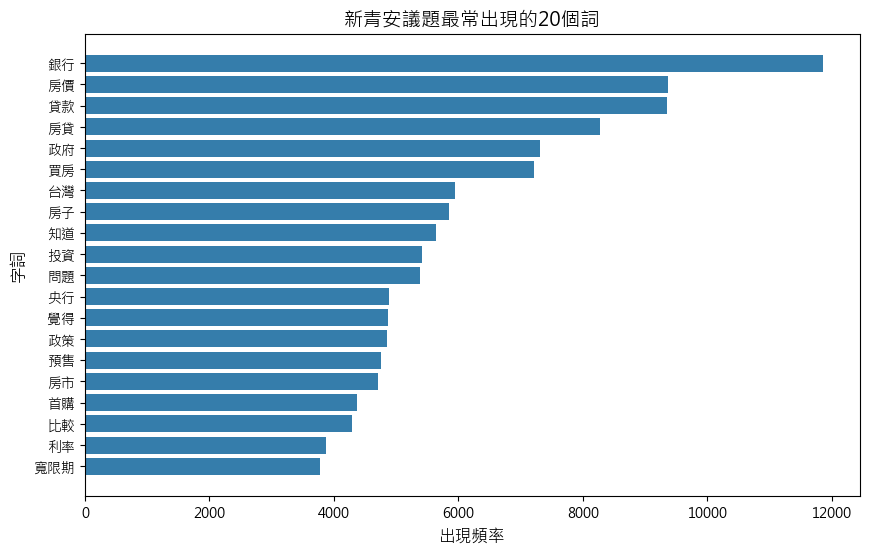

In [24]:
# 計算常出現的字
word_frq = data.groupby(['word'],as_index=False).size()
word_frq.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_frq = word_frq[word_frq['size']>10]  # 過濾出現太少次的字

# 過濾掉新青安的詞 
exclude_words = ['新青安','青年安心成家貸款','青安貸款','青年安心成家購屋','青年首購貸款']
word_frq = word_frq[~word_frq['word'].isin(exclude_words)] 

# 繪製前20常出現的字
n = 20
plot_n = word_frq.head(20)

plt.figure(figsize = (10,6))
plt.barh(plot_n['word'], plot_n['size'], color = '#357dab')
plt.xlabel('出現頻率', fontsize = 12)
plt.ylabel('字詞', fontsize = 12)
plt.title('新青安議題最常出現的20個詞', fontsize = 14)
plt.gca().invert_yaxis()
plt.show()

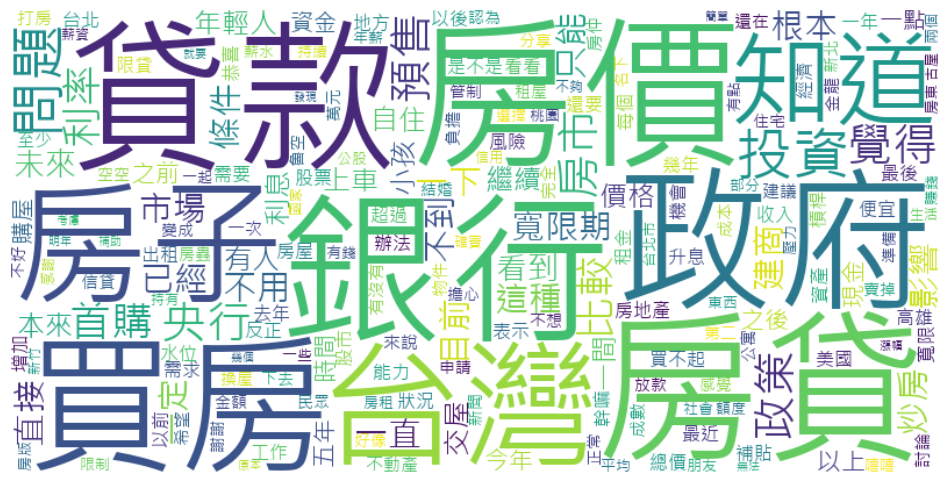

In [25]:
# 繪製文字雲
word = " ".join(word_frq['word'].to_list())

wc = WordCloud(
    font_path='msjh.ttc',
    width = 800,
    height = 400, background_color='white'
).generate(word)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2. Lexicon-based 情緒分析 

In [26]:
# 載入liwc檔案

# 建立空的list
d_liwc = []

for label in ["positive", "negative"]:
    filename = f"./liwc/{label}.txt"
    with open(filename, "r", encoding="utf-8") as f:
        # 讀檔，以逗號分開
        words = f.read().strip().split(",")
        words = [w.strip() for w in words if w.strip()]  # 去掉空白
        for w in words:
            d_liwc.append([w, label])

df_liwc = pd.DataFrame(d_liwc, columns=["word", "sentiments"])

In [27]:
df_liwc

word sentiments
0      ﻿一流   positive
1     下定決心   positive
2     不拘小節   positive
3      不費力   positive
4       不錯   positive
...    ...        ...
1706    麻煩   negative
1707    默哀   negative
1708    黯淡   negative
1709    鼻酸   negative
1710    齷齪   negative

[1711 rows x 2 columns]

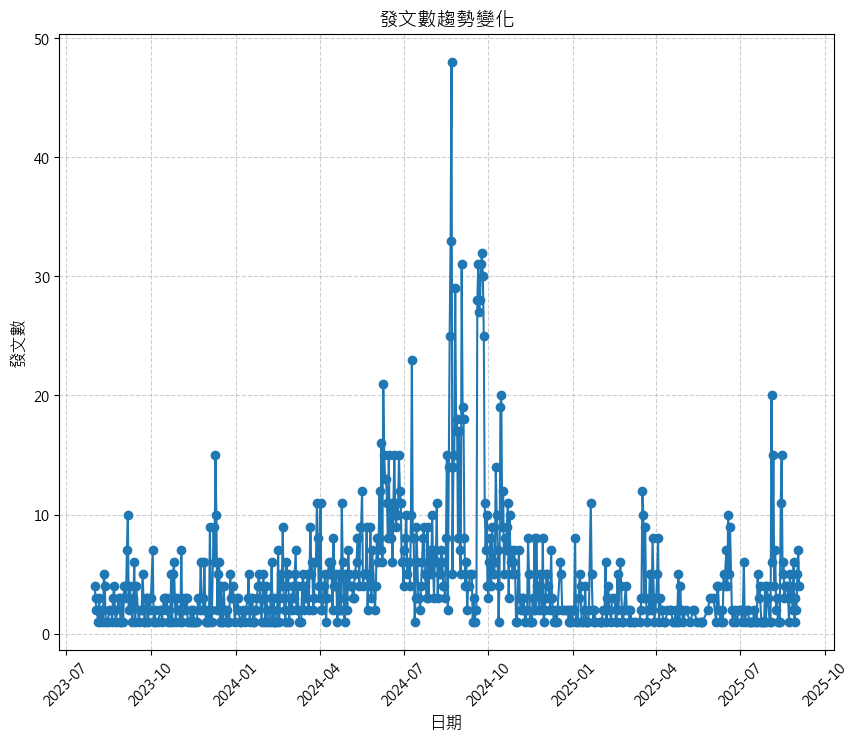

In [28]:
article['date'] = pd.to_datetime(article['date'], errors= 'coerce') # pd.to_datetime語法 : errors用來處理轉換失敗的值
create_frq = article.groupby(article['date'].dt.date).size()

plt.figure(figsize=(10,8))
plt.plot(create_frq.index, create_frq.values, marker = 'o', linestyle = '-')
plt.title('發文數趨勢變化',fontsize = 14)
plt.xlabel('日期', fontsize = 12)
plt.ylabel('發文數', fontsize = 12)
plt.xticks(rotation = 45)
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.show()


In [29]:
create_frq.sort_values(ascending=False).reset_index(name='count').head(10)

date  count
0  2024-08-22     48
1  2024-08-21     33
2  2024-09-24     32
3  2024-09-20     31
4  2024-09-02     31
5  2024-09-23     31
6  2024-09-25     30
7  2024-08-26     29
8  2024-09-22     28
9  2024-09-19     28

此部分進一步分析發文數前10名的日期，並檢視其內文與標題，辨識當時被熱烈討論的議題，並嘗試連結可能的外部事件脈絡。

In [30]:
df_liwc

word sentiments
0      ﻿一流   positive
1     下定決心   positive
2     不拘小節   positive
3      不費力   positive
4       不錯   positive
...    ...        ...
1706    麻煩   negative
1707    默哀   negative
1708    黯淡   negative
1709    鼻酸   negative
1710    齷齪   negative

[1711 rows x 2 columns]

#### 2.1 正負向情緒分數聲量折線圖

In [31]:
# 合併文章斷詞與情緒字典(保留同時存在於文章裡，又在情緒字典裡的詞)
data_liwc = pd.merge(article_token, df_liwc, on='word', how='inner')
data_liwc

title  \
0                                 [請益] 房貸選擇   
1                    [新聞] 全台房價 自歷史高點回落0.59％   
2                    [新聞] 全台房價 自歷史高點回落0.59％   
3                    [新聞] 全台房價 自歷史高點回落0.59％   
4                    [新聞] 全台房價 自歷史高點回落0.59％   
...                                     ...   
31450  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
31451  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
31452  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
31453  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
31454  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                     url  \
0      https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1      https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2      https://www.ptt.cc/bbs/home-sale/M.1756870821....   
3      https://www.ptt.cc/bbs/home-sale/M.1756870821....   
4      https://www.ptt.cc/bbs/home-sale/M.1756870821....   
...                                                  ...   
31450  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
31451  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
31452  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
31453  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
31454  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                 content        date  \
0      貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1      全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03   
2      全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03   
3      全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03   
4      全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03   
...                                                  ...         ...   
31450  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
31451  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
31452  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
31453  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
31454  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                          filter_content word sentiments  
0      貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   值得   positive  
1      全台房價自歷史高點回落郭及天台北報導年月日週一上午去年月日央行第七波選擇性信用管制出爐成為這...   無力   negative  
2      全台房價自歷史高點回落郭及天台北報導年月日週一上午去年月日央行第七波選擇性信用管制出爐成為這...   支撐   positive  
3      全台房價自歷史高點回落郭及天台北報導年月日週一上午去年月日央行第七波選擇性信用管制出爐成為這...   驚人   positive  
4      全台房價自歷史高點回落郭及天台北報導年月日週一上午去年月日央行第七波選擇性信用管制出爐成為這...   驚人   negative  
...                                                  ...  ...        ...  
31450  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   不利   negative  
31451  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   協助   positive  
31452  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   免費   positive  
31453  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   相信   positive  
31454  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   困擾   negative  

[31455 rows x 7 columns]

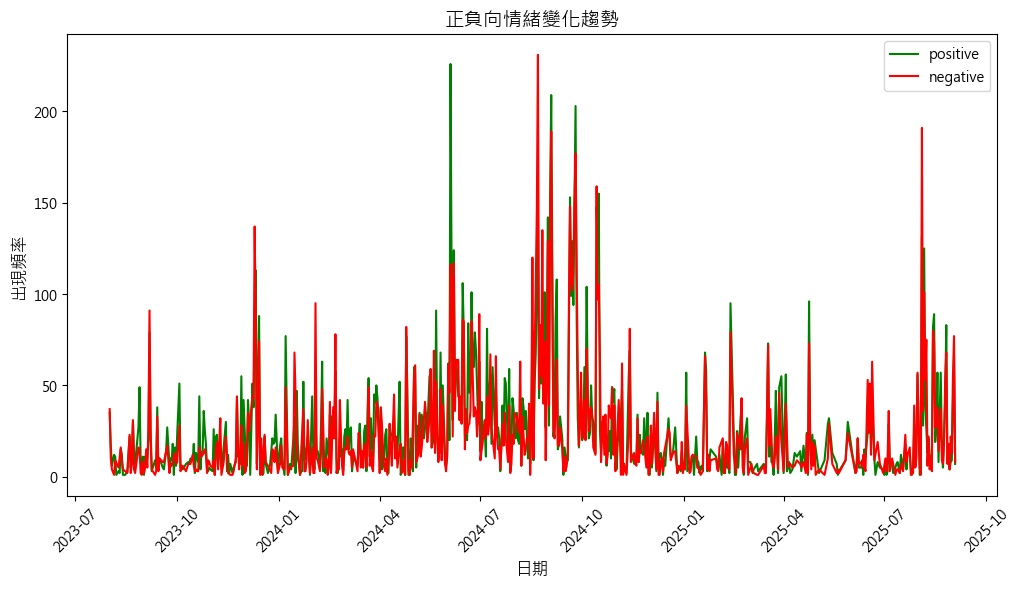

In [32]:
# 計算每日的情緒數量並繪製成折線圖
sentiment_count = (data_liwc.groupby(['date','sentiments']).size().reset_index(name='count'))

plt.figure(figsize=(12,6))
for sentiment, color in zip(['positive','negative'],['green','red']): # 分別處理
    subset = sentiment_count[sentiment_count['sentiments'] == sentiment]
    plt.plot(subset['date'], subset['count'], label = sentiment, color = color)

plt.legend()
plt.title('正負向情緒變化趨勢', fontsize = 14)
plt.xlabel('日期', fontsize = 12)
plt.ylabel('出現頻率', fontsize = 12)
plt.xticks(rotation = 45)
plt.show()

In [33]:
# 前10正向聲量最高的日期
sentiment_count[sentiment_count['sentiments'] == 'positive'].sort_values('count', ascending=False)

date sentiments  count
517   2024-06-04   positive    226
695   2024-09-03   positive    209
736   2024-09-25   positive    203
776   2024-10-16   positive    155
726   2024-09-20   positive    153
...          ...        ...    ...
145   2023-11-04   positive      1
46    2023-09-01   positive      1
87    2023-09-28   positive      1
1182  2025-08-02   positive      1
10    2023-08-07   positive      1

[635 rows x 3 columns]

In [34]:
# 前10負向聲量最高的日期
sentiment_count[sentiment_count['sentiments'] == 'negative'].sort_values('count', ascending=False)

date sentiments  count
670   2024-08-22   negative    231
1185  2025-08-04   negative    191
694   2024-09-03   negative    189
735   2024-09-25   negative    177
771   2024-10-14   negative    159
...          ...        ...    ...
439   2024-04-24   negative      1
1148  2025-07-11   negative      1
407   2024-04-08   negative      1
1168  2025-07-25   negative      1
41    2023-08-30   negative      1

[610 rows x 3 columns]

#### 2.2 正負向情緒分數比例折線圖

In [35]:
daily_total = sentiment_count.groupby('date')['count'].sum().reset_index(name = 'daily_total')
sentiment_countr = sentiment_count.merge(daily_total, on='date', how='left')
sentiment_countr['ratio'] = sentiment_countr['count'] / sentiment_countr['daily_total']
sentiment_countr

date sentiments  count  daily_total     ratio
0     2023-08-01   negative     37           72  0.513889
1     2023-08-01   positive     35           72  0.486111
2     2023-08-02   negative     10           27  0.370370
3     2023-08-02   positive     17           27  0.629630
4     2023-08-03   negative      4           10  0.400000
...          ...        ...    ...          ...       ...
1240  2025-09-01   positive     41           95  0.431579
1241  2025-09-02   negative     77          142  0.542254
1242  2025-09-02   positive     65          142  0.457746
1243  2025-09-03   negative      8           15  0.533333
1244  2025-09-03   positive      7           15  0.466667

[1245 rows x 5 columns]

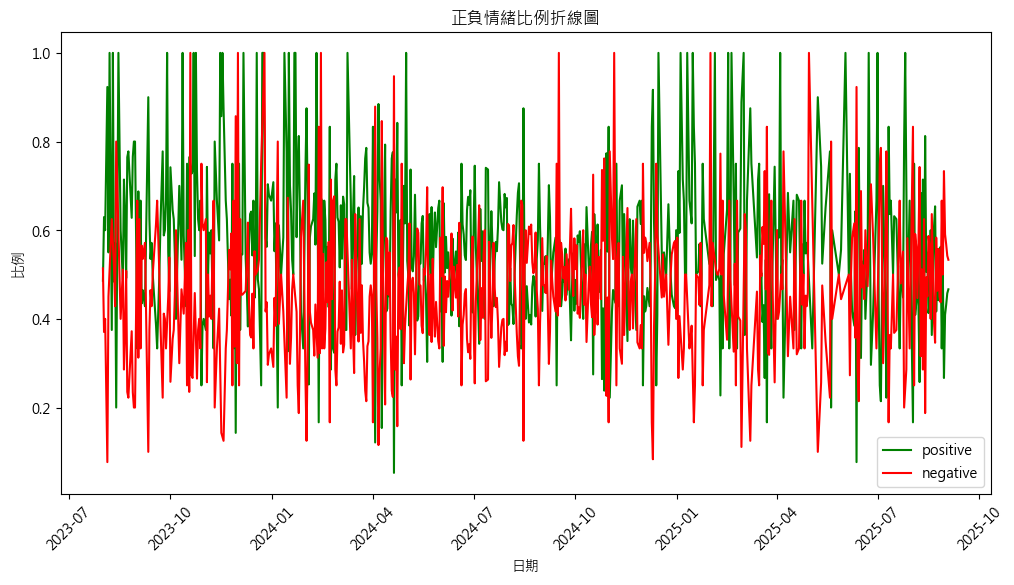

In [36]:
plt.figure(figsize=(12,6))

for sentiment, color in zip(['positive','negative'],['green','red']):
    subset = sentiment_countr[sentiment_countr['sentiments'] == sentiment]
    plt.plot(subset['date'], subset['ratio'], label = sentiment, color = color) 

plt.legend()
plt.title('正負情緒比例折線圖')
plt.xlabel('日期')
plt.ylabel('比例')
plt.xticks(rotation = 45)
plt.show()

#### 2.3 正負向情緒代表字

In [37]:
# 計算正負向情緒前20名的詞
sentiment_frq =  data_liwc.groupby(['sentiments','word']).size().reset_index(name='count') 
top20_pos = sentiment_frq[sentiment_frq['sentiments'] == 'positive'].nlargest(20, 'count')
top20_neg = sentiment_frq[sentiment_frq['sentiments'] == 'negative'].nlargest(20, 'count')

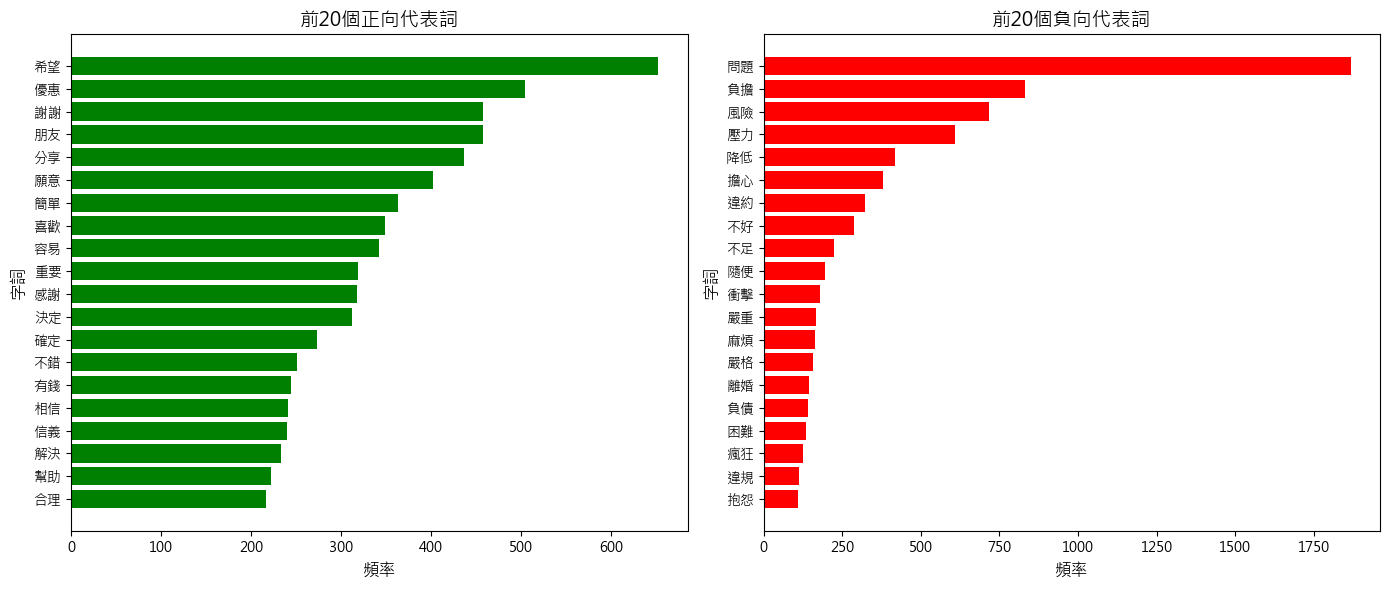

In [38]:
fig, axes = plt.subplots(1, 2, figsize = (14,6))

axes[0].barh(top20_pos['word'], top20_pos['count'], color = 'green')
axes[0].set_title('前20個正向代表詞', fontsize = 14)
axes[0].invert_yaxis() # 數量最多排最前面
axes[0].set_xlabel('頻率', fontsize = 12)
axes[0].set_ylabel('字詞', fontsize = 12)


axes[1].barh(top20_neg['word'], top20_neg['count'], color = 'red')
axes[1].set_title('前20個負向代表詞', fontsize = 14)
axes[1].invert_yaxis()
axes[1].set_xlabel('頻率', fontsize = 12)
axes[1].set_ylabel('字詞', fontsize = 12)

plt.tight_layout()
plt.show()



#### 2.4 文字雲
- 針對正負面聲量相差最多的時間分析

##### 2024-06-04正向聲量最高

In [39]:
data_liwc['date'] = pd.to_datetime(data_liwc['date'], errors = 'coerce')
pos_words = data_liwc[(data_liwc['date'] == '2024-06-04') & 
                      (data_liwc['sentiments'] == 'positive')]['word']
pos_words

21684    優點
21687    確定
21688    優點
21690    感謝
21691    感謝
         ..
22011    解決
22015    決定
22019    解決
22023    復甦
22024    吸引
Name: word, Length: 226, dtype: object

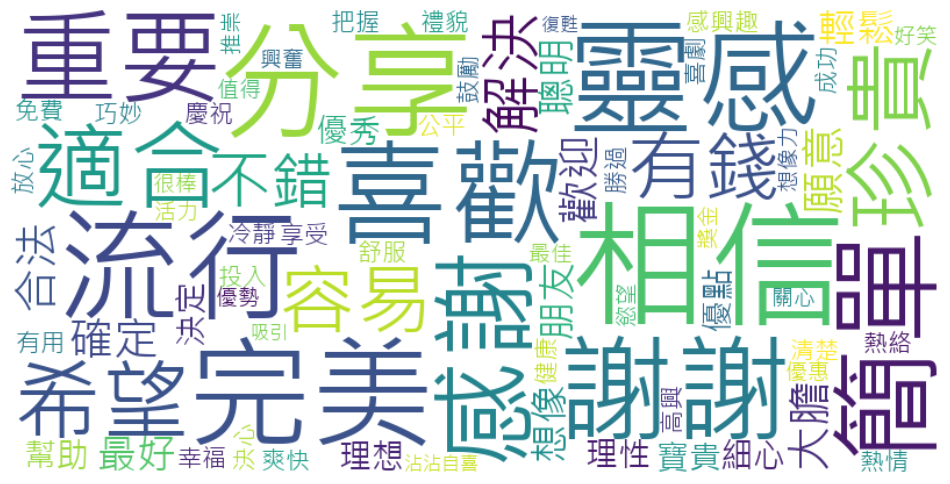

In [40]:
pos_list = " ".join(pos_words.to_list())

pos_wc = WordCloud(
    font_path='msjh.ttc',
    width=800,
    height=400,
    background_color='white'
).generate(pos_list)

plt.figure(figsize=(12,10))
plt.imshow(pos_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

##### 2024-08-22 負向聲量最高

In [41]:
neg_words = data_liwc[(data_liwc['date'] == '2024-08-22') & (data_liwc['sentiments'] == 'negative')]['word']
neg_words  

15287    緊繃
15288    受害
15289    困擾
15296    衝擊
15298    違約
         ..
15673    負擔
15676    問題
15677    負擔
15678    負擔
15679    風險
Name: word, Length: 231, dtype: object

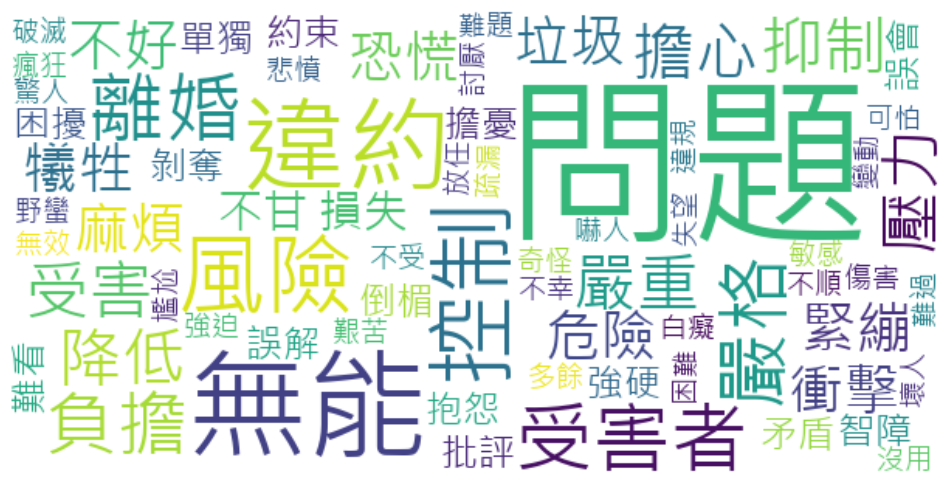

In [42]:
neg_list = " ".join(neg_words.to_list())

neg_wc = WordCloud(
    font_path='msjh.ttc',
    width=600,
    height=300,
    background_color='white'
).generate(neg_list)

plt.figure(figsize=(12,10))
plt.imshow(neg_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### 3. CKIP 

In [43]:
# # 下載ckip model
# data_utils.download_data_gdown("./")

In [44]:
# To use CPU
ws = WS('./data')
pos = POS('./data')
ner = NER('./data')


c:\Users\Shelly\new_anaconda3\envs\loan\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\Shelly\new_anaconda3\envs\loan\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\Shelly\new_anaconda3\envs\loan\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v

#### 3.1 使用CKIP進行分析

In [45]:
article = pd.read_csv('./raw_data/articles.csv')
article

title              time  \
0                                [請益] 房貸選擇  2025/09/03 11:34   
1                   [新聞] 全台房價 自歷史高點回落0.59％  2025/09/03 11:40   
2                    [請益] 關於內政部的自購住宅貸款利息補貼  2025/09/03 13:35   
3             Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎  2025/09/03 16:21   
4             Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭  2025/09/02 17:14   
...                                    ...               ...   
3089              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上  2023/08/01 23:51   
3090             Re: [閒聊] 85年次以後的年輕工程師有多慘？  2023/08/02 01:28   
3091          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊  2023/08/02 09:01   
3092               [新聞] 新青安房貸今上路 建商救命浮木來了？  2023/08/01 18:52   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限  2023/08/01 07:54   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1     https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2     https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3     https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4     https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                 ...   
3089  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
3090  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
3091  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
3092  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content  
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  
1     全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  
2     爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  
3     鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  
4     : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  
...                                                 ...  
3089  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  
3090  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  
3091  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  
3092  連結：\nhttps://money.udn.com/money/story/5621/73...  
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  

[3094 rows x 4 columns]

In [46]:
article.insert(0, 'status_id', range(1, len(article)+1))
article

status_id                                 title              time  \
0             1                             [請益] 房貸選擇  2025/09/03 11:34   
1             2                [新聞] 全台房價 自歷史高點回落0.59％  2025/09/03 11:40   
2             3                 [請益] 關於內政部的自購住宅貸款利息補貼  2025/09/03 13:35   
3             4          Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎  2025/09/03 16:21   
4             5          Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭  2025/09/02 17:14   
...         ...                                   ...               ...   
3089       3090              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上  2023/08/01 23:51   
3090       3091             Re: [閒聊] 85年次以後的年輕工程師有多慘？  2023/08/02 01:28   
3091       3092          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊  2023/08/02 09:01   
3092       3093               [新聞] 新青安房貸今上路 建商救命浮木來了？  2023/08/01 18:52   
3093       3094  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限  2023/08/01 07:54   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1     https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2     https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3     https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4     https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                 ...   
3089  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
3090  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
3091  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
3092  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content  
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  
1     全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  
2     爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  
3     鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  
4     : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  
...                                                 ...  
3089  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  
3090  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  
3091  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  
3092  連結：\nhttps://money.udn.com/money/story/5621/73...  
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  

[3094 rows x 5 columns]

In [53]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except Exception as e:
            print("Error", e)
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [48]:
with open('./dict/user_dict.txt', 'r', encoding='utf-8') as f:
    words = f.read().splitlines()

# 過濾掉空行
words = [w.strip() for w in words if w.strip()]

# 因為只是要避免詞被切錯，所以都給1.0的權重就好
dict_custom = {w: 1.0 for w in words}

dictionary2 = construct_dictionary(dict_custom)
print(dictionary2)


[(2, {'全台': 1.0, '綁約': 1.0, '房價': 1.0, '指數': 1.0, '都會': 1.0, '雲林': 1.0, '逢低': 1.0, '名下': 1.0, '新北': 1.0, '卓揆': 1.0, '局長': 1.0, '首購': 1.0, '炒房': 1.0, '寬容': 1.0, '貸款': 1.0, '鬆綁': 1.0, '國銀': 1.0, '承作': 1.0, '八成': 1.0, '周轉': 1.0, '承擔': 1.0, '風險': 1.0, '八大': 1.0, '公股': 1.0, '搭售': 1.0, '房貸': 1.0, '放款': 1.0, '銀行': 1.0, '金融': 1.0, '限縮': 1.0, '民眾': 1.0, '自住': 1.0, '存款': 1.0, '利率': 1.0, '基金': 1.0, '資金': 1.0, '原則': 1.0, '啟動': 1.0, '善盡': 1.0, '爭議': 1.0, '高雄': 1.0, '台北': 1.0, '新竹': 1.0, '桃園': 1.0, '台南': 1.0, '成數': 1.0, '交屋': 1.0, '預售': 1.0, '簽約': 1.0, '解約': 1.0, '拋售': 1.0, '水位': 1.0, '信貸': 1.0, '法拍': 1.0, '風控': 1.0, '明文': 1.0, '禁止': 1.0, '壽險': 1.0, '分母': 1.0, '透明': 1.0, '金檢': 1.0, '查核': 1.0, '檢查': 1.0, '揭露': 1.0, '督促': 1.0, '法源': 1.0, '限制': 1.0, '天際': 1.0, '寬限': 1.0, '排撥': 1.0, '規定': 1.0, '違反': 1.0, '自用': 1.0, '央行': 1.0, '補助': 1.0, '增貸': 1.0, '政治': 1.0, '警戒': 1.0, '所需': 1.0, '額度': 1.0, '房仲': 1.0, '囤房': 1.0, '違約': 1.0, '限貸': 1.0, '金龍': 1.0, '鴻海': 1.0, '轉介': 1.0, '就業': 1.0, '機會': 1.0, '托育': 1.0, '社畜'

In [49]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['content']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['status_id'],sentence])            
            temp_tokens = get_pos(row['status_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['status_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['status_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['status_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['status_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [50]:
# pos_table, entity_table, sentence_table = get_nlp_result(article)


In [51]:
# # 將結果儲存成csv檔，方便後來分析
# pos_table.to_csv('./raw_data/pos_table.csv', index=False)
# entity_table.to_csv('./raw_data/entity_table.csv', index=False)
# sentence_table.to_csv('./raw_data/sentence_table.csv', index=False)


#### 3.2 NER分析

In [52]:
entity_table = pd.read_csv('./raw_data/entity_table.csv')
sentence_table = pd.read_csv('./raw_data/sentence_table.csv')
pos_table = pd.read_csv('./raw_data/pos_table.csv')
entity_table['ner'].unique()

array(['PERSON', 'GPE', 'TIME', 'DATE', 'ORDINAL', 'ORG', 'EVENT',
       'CARDINAL', 'FAC', 'NORP', 'LAW', 'QUANTITY', 'PERCENT',
       'LANGUAGE', 'MONEY', 'LOC', 'WORK_OF_ART', 'PRODUCT'], dtype=object)

In [54]:
entity_table

Unnamed: 0  status_id     word       ner
0               0          1      新青安    PERSON
1               1          2        郭    PERSON
2               2          2       台北       GPE
3               3          2  年月日週一上午      TIME
4               4          2      去年月      DATE
...           ...        ...      ...       ...
64521       64521       3094     行政院長       ORG
64522       64522       3094      陳建仁    PERSON
64523       64523       3094       青安       GPE
64524       64524       3094      陳建仁    PERSON
64525       64525       3094        一  CARDINAL

[64526 rows x 4 columns]

In [55]:
# 因為領域關係，原本的實體表的結果並不理想，故增加規則以修正某些結果
rules = {
    "新青安":"EVENT", # 關鍵字/修正標籤
    "金龍":"PERSON",
    "清華安富":"PRODUCT",
    "經濟部長":"PERSON",
    "八里五股":"LOC",
    "青安":"EVENT",
    "民進黨":"NORP",
    "台灣":"GPE",
    "美國":"GPE",
    "美債":"PRODUCT",
    "日本":"GPE",
    "高雄":"GPE",
    "中國":"GPE",
    "英國":"GPE",
    "法國":"GPE"
}

def fix_ner(row):
    for k, v in rules.items():
        if k in row['word']:
            return v
    return row['ner']

entity_table['ner'] = entity_table.apply(fix_ner, axis = 1)

In [56]:
entity_table

Unnamed: 0  status_id     word       ner
0               0          1      新青安     EVENT
1               1          2        郭    PERSON
2               2          2       台北       GPE
3               3          2  年月日週一上午      TIME
4               4          2      去年月      DATE
...           ...        ...      ...       ...
64521       64521       3094     行政院長       ORG
64522       64522       3094      陳建仁    PERSON
64523       64523       3094       青安     EVENT
64524       64524       3094      陳建仁    PERSON
64525       64525       3094        一  CARDINAL

[64526 rows x 4 columns]

In [57]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False)
ner_count

ner  count
1          DATE  13839
4           GPE  12065
0      CARDINAL  10320
13       PERSON   6775
11          ORG   6668
2         EVENT   5293
10      ORDINAL   3047
8         MONEY   2390
7           LOC   1150
3           FAC    887
12      PERCENT    484
16         TIME    472
9          NORP    400
6           LAW    302
15     QUANTITY    210
17  WORK_OF_ART    141
14      PRODUCT     54
5      LANGUAGE     29

C:\Users\Shelly\AppData\Local\Temp\ipykernel_41756\1510725383.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


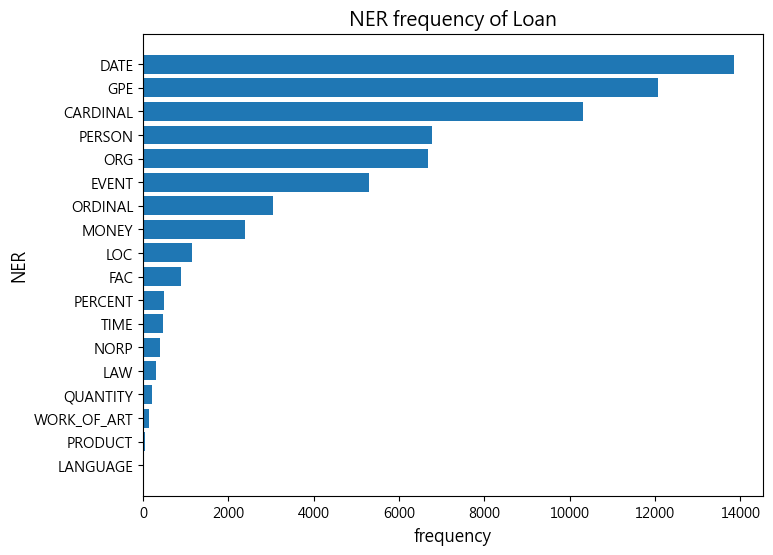

In [58]:
fig, ax = plt.subplots(figsize = (8,6))

ax.barh(ner_count['ner'], ner_count['count'])
ax.invert_yaxis()
ax.set_title('NER frequency of Loan',fontsize = 14)
ax.set_ylabel('NER', fontsize = 12)
ax.set_xlabel('frequency', fontsize = 12)

fig.show()

##### 涉及到的人名(PERSON)

Text(0.5, 0, 'Frequency')

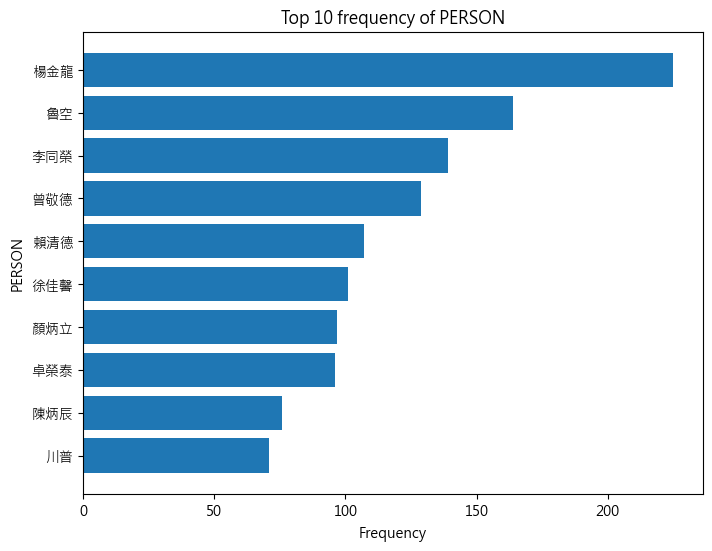

In [59]:
# 因為輸出發現楊金龍、金龍皆上榜，故合併兩詞
PERSON = entity_table[entity_table['ner'] == "PERSON"].groupby('word')['word'].count().reset_index(name="count")

# 依照條件清裡
PERSON = PERSON[PERSON['word'].str.len()>1]
PERSON['word'] = PERSON['word'].replace({"金龍":"楊金龍"})

# 因為replace的word也會被算入，所以前10要加1
PERSON = PERSON.sort_values('count', ascending=False).head(11)

fig, ax = plt.subplots(figsize = (8,6))
ax.barh(PERSON['word'], PERSON['count'])
ax.invert_yaxis()
ax.set_title("Top 10 frequency of PERSON")
ax.set_ylabel("PERSON")
ax.set_xlabel("Frequency")

- 進一步分析提及頻率的一、二名PERSON：楊金龍、魯空  
因為楊金龍為央行的總裁，所以在解釋新青安相關議題的時候常會被提及;至於提及數第二的魯空則代表無殼族，對新青安的態度抱持厭惡的看法。

In [60]:
key_word = ["楊金龍","魯空"]
sentence_table[sentence_table['sentence'].str.contains("|".join(key_word))]

Unnamed: 0  status_id                                sentence
145            145          5                這邊參考一下國外月亮比較圓的魯空最愛的美國的做法
857            857         17                           原來楊金龍說的鼓勵家戶投資
1043          1043         24                          反觀楊金龍還是上屆總統提名的
1051          1051         24                   央行沒有依法行政沒彈劾你楊金龍已經很客氣了
2459          2459         47  是啊，感到悲憤焦慮剝奪感，房價也不會因此變便宜，我不是第一個魯空，也不會是最
...            ...        ...                                     ...
124632      124632       3010                房蟲就是一直買一直爽，魯空就是一直租一直哭房價高
124653      124653       3010                           魯空已經習慣活在平行時空了
124731      124731       3010                               人貴自知魯空是例外
127281      127281       3079                        魯空該擔心的是到時飯碗你還在不在
127283      127283       3079                         魯空真的以為銀行很想推年房貸嗎

[510 rows x 3 columns]

##### 涉及到的組織(ORG)

Text(0.5, 0, 'Frequency')

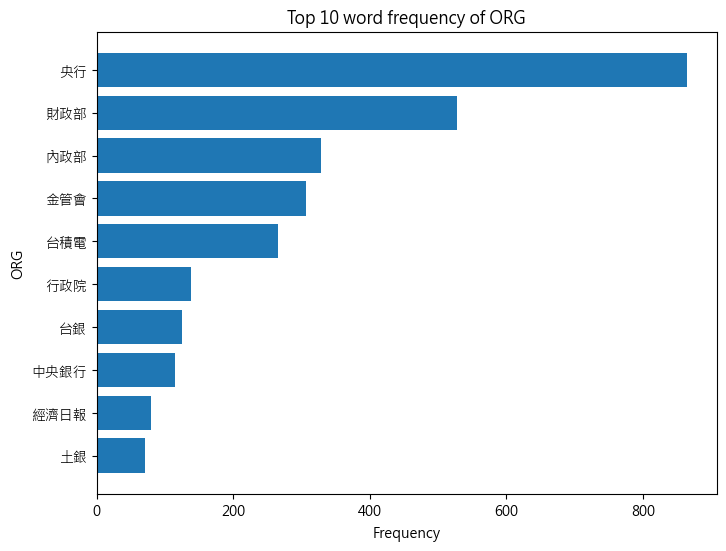

In [61]:
ORG = entity_table[entity_table['ner'] == 'ORG'].groupby('word')['word'].count().reset_index(name='count').sort_values('count',ascending=False).head(10)

fig, ax = plt.subplots(figsize = (8,6))

ax.barh(ORG['word'],ORG['count'])
ax.invert_yaxis()
ax.set_title('Top 10 word frequency of ORG')
ax.set_ylabel('ORG')
ax.set_xlabel('Frequency')

- 進一步分析提及頻率最高的ORG：央行、財政部  
因為信用管制與房貸的相關議題與央行有關，所以常被提及。例如，行政院鬆綁新青安(水龍頭)，央行出面說明放寬內容;
財政部則是公告新青安相關資訊的地方，如條件與限制，所以也常被提及。

In [62]:
key_word1 = ['央行','財政部']
sentence_table[sentence_table['sentence'].str.contains("|".join(key_word1))]

Unnamed: 0  status_id                                sentence
19              19          2  去年月日央行第七波選擇性信用管制出爐，成為這波房市多頭的轉折點，全台房價在去
28              28          2   月攀上的最高峰，之後隨著央行信用管制及銀行房貸放款緊縮，房市交易量急凍，高
83              83          5                     連結金管會央行邀銀行研議開大房貸水龍頭
94              94          5               央行也找了數家銀行總座去喝咖啡，詢問目前房貸的承作
121            121          5      房貸卡關，不外乎兩項原因，一是銀行法條的三成上限滿水位，二是受限央行
...            ...        ...                                     ...
126286      126286       3051  為健全房市並協助無自有住宅家庭購屋自住，財政部青年安心成家購屋優惠貸款下稱青
126290      126290       3051    財政部表示，青安貸款適用對象係成年，本人配偶及未成年子女無自有住宅者，民
127285      127285       3079                       你做空房地產就是在跟央行和政府對做
127395      127395       3084  平均地權條例上路效應開始發酵央行推出第五波房市管制措施等影響下，設廠題材被過
127850      127850       3093   手與央行祭出第二戶限貸令的衝擊下，新推案買氣都相當低落，第季新推案，天內銷

[2982 rows x 3 columns]

##### 涉及到的國籍、宗教或政治團體(NORP)

In [63]:
NORP = entity_table[entity_table['ner'] == "NORP"].groupby('word')['word'].count().reset_index(name='count').sort_values('count', ascending=False)
NORP = entity_table[entity_table['word'].str.len()>1]
NORP


Unnamed: 0  status_id     word      ner
0               0          1      新青安    EVENT
2               2          2       台北      GPE
3               3          2  年月日週一上午     TIME
4               4          2      去年月     DATE
5               5          2       第七  ORDINAL
...           ...        ...      ...      ...
64520       64520       3094      林依榕   PERSON
64521       64521       3094     行政院長      ORG
64522       64522       3094      陳建仁   PERSON
64523       64523       3094       青安    EVENT
64524       64524       3094      陳建仁   PERSON

[56101 rows x 4 columns]

Text(0.5, 0, 'Frequency')

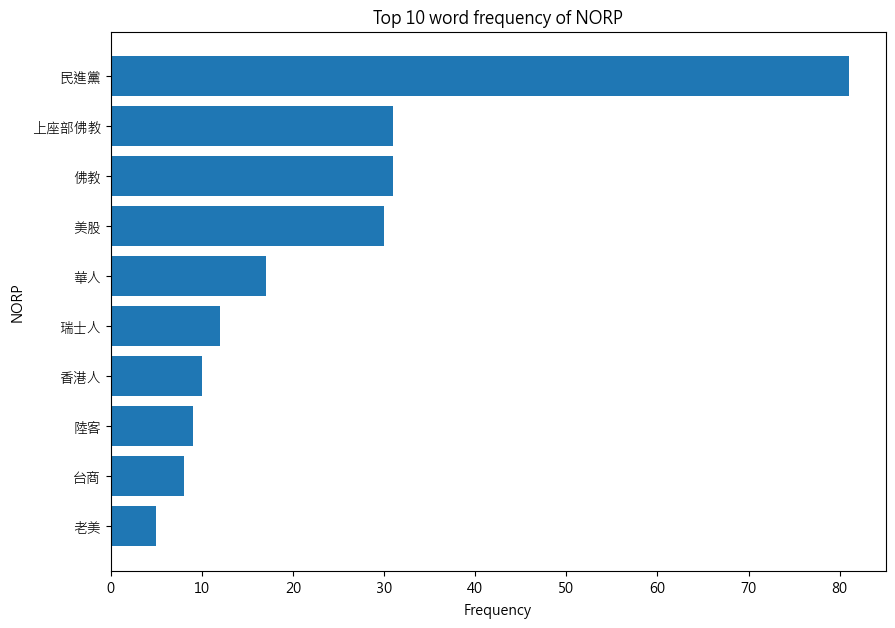

In [64]:
NORP = entity_table[entity_table['ner'] == 'NORP'].groupby('word')['word'].count().reset_index(name="count")
NORP = NORP[NORP['word'].str.len()>1]

NORP = NORP.sort_values('count',ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,7))
ax.barh(NORP['word'], NORP['count'])
ax.invert_yaxis()
ax.set_title("Top 10 word frequency of NORP")
ax.set_ylabel("NORP")
ax.set_xlabel("Frequency")


- 進一步分析提及頻率最高的NORP：民進黨  
因為新青安方案推出時的執政黨為民進黨，所以在討論上常出現


In [65]:
key_word2 = "民進黨"
sentence_table[sentence_table['sentence'].str.contains(key_word2)]

Unnamed: 0  status_id                                sentence
3129          3129         59  房價準備崩了，民進黨前桃園市議員王浩宇在臉書發文表示，看到最新數字，所有的預
3325          3325         64         民進黨遲遲無法解決楊金龍帶來的房貸緊縮問題，導致大家買不了房，
3491          3491         67                以前是有長老教會在民進黨鎮妖魔鬼怪才沒那麼多鳥事
3492          3492         67                           但自從菜英文到民進黨都變了
3506          3506         68                            其實你應該怪的不是民進黨
...            ...        ...                                     ...
126172      126172       3047   內政部次長花敬群民進黨前主席卓榮泰與會，全國地政士後援會榮譽總會長黃志偉全
126211      126211       3048                           民進黨的新青安炒房政策廢除
126220      126220       3048                      民進黨政府高層郭總統肯定會開始查弊案
126504      126504       3057   說實在，懂的就知道降息的時候就是要崩盤了高雄這種鳥地方遲早，民進黨再怎麼亂
126713      126713       3060                    民進黨一定把官股行庫全部叫過去宣導了一輪

[82 rows x 3 columns]

#### 3.3 POS分析

In [66]:
# 辨識出哪些POS種類
pos_table['pos'].unique()

array(['Na', 'VC', 'VB', 'Nc', 'VH', 'Nb', 'VJ', 'Neu', 'D', 'VE', 'Neqa',
       'T', 'Dfa', 'Nh', 'Nf', 'Ng', 'VA', 'COMMACATEGORY', 'VK', 'VG',
       'SHI', 'Cba', 'P', 'Caa', 'Nd', 'Nep', 'DE', 'VCL', 'VL', 'Ncd',
       'Da', 'A', 'Nes', 'Nv', 'VD', 'VI', 'Cbb', 'Cab', 'V_2', 'VAC',
       'FW', 'Di', 'VF', 'VHC', 'Dfb', 'Neqb', 'Dk', 'I', 'DM',
       'COLONCATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY',
       'ETCCATEGORY'], dtype=object)

- 出現頻率為前10的POS種類

In [67]:
filter = ['COMMACATEGORY','PARENTHESISCATEGORY','PERIODCATEGORY','COLONCATEGORY']
POS = pos_table[~pos_table['pos'].isin(filter)].groupby('pos')['pos'].count().reset_index(name='count').sort_values('count',ascending=False).head(10)
POS

pos   count
16   Na  252496
5     D  156820
36   VC   87820
42   VH   78070
18   Nc   49080
6    DE   45967
30    P   41316
26   Nf   39403
28   Nh   34089
25  Neu   33871

Text(0.5, 0, 'Frequency')

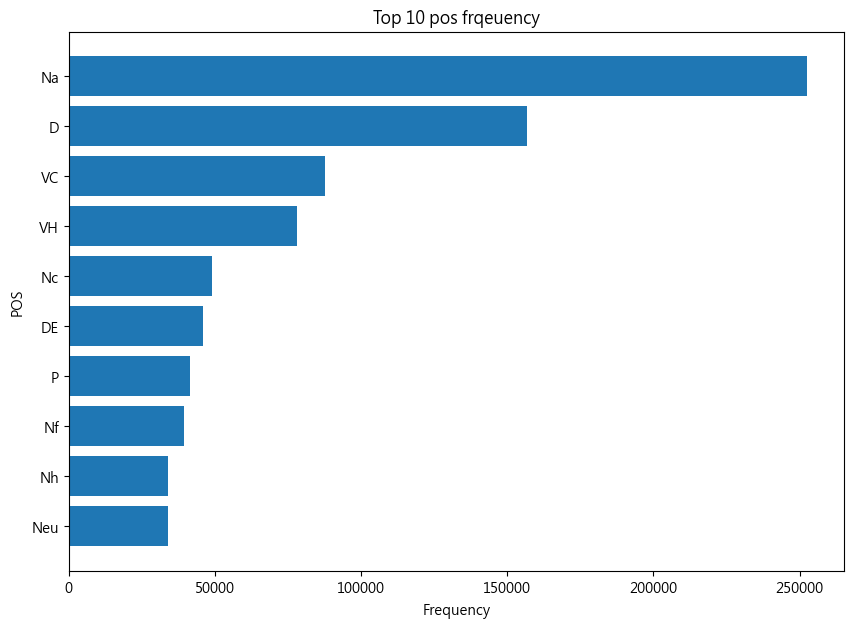

In [68]:
fig, ax = plt.subplots(figsize = (10,7))

ax.barh(POS['pos'], POS['count'])
ax.invert_yaxis()
ax.set_title("Top 10 pos frqeuency")
ax.set_ylabel('POS')
ax.set_xlabel('Frequency')

##### 涉及到的名詞(Nb)

Text(0.5, 0, 'Frequency')

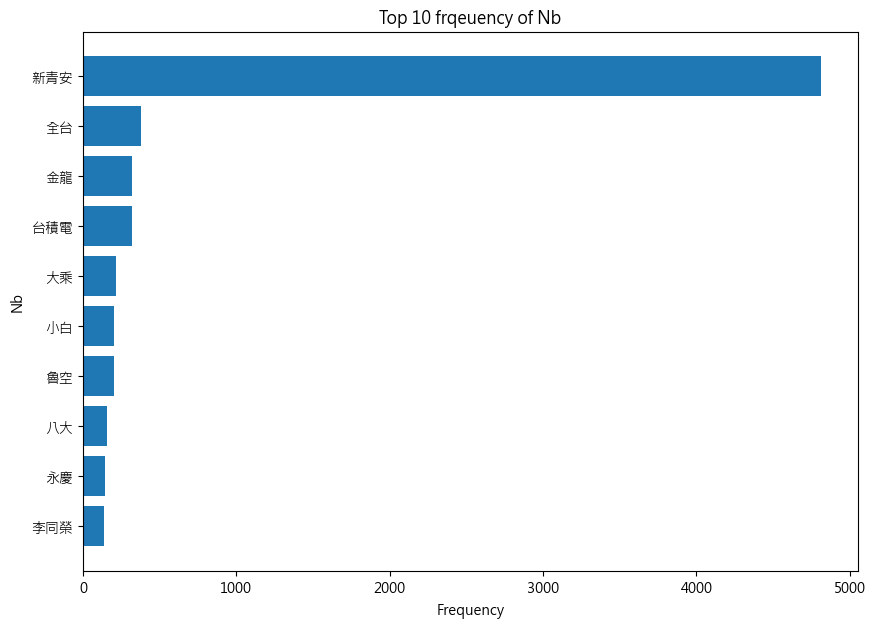

In [69]:
# 此部分選擇特定專有名詞分析
Nb = pos_table[pos_table['pos'] == 'Nb'].groupby('word')['word'].count().reset_index(name = 'count')
Nb = Nb[Nb['word'].str.len()>1].sort_values('count',ascending=False).head(10)

fig, ax = plt.subplots(figsize = (10,7))

ax.barh(Nb['word'], Nb['count'])
ax.invert_yaxis()
ax.set_title("Top 10 frqeuency of Nb")
ax.set_ylabel('Nb')
ax.set_xlabel('Frequency')

##### 涉及到的動詞(VERB)

Text(0.5, 0, 'Frequency')

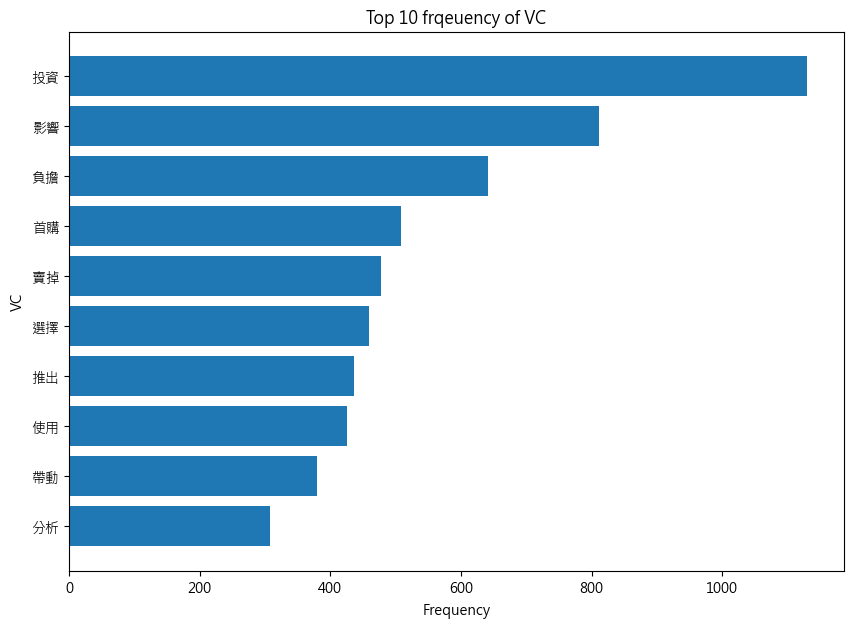

In [70]:
# 此部分選擇VC(動作及物動詞)
VC = pos_table[pos_table['pos'] == 'VC'].groupby('word')['word'].count().reset_index(name = 'count')
VC = VC[VC['word'].str.len()>1].sort_values('count',ascending=False)
VC = VC[~VC['word'].isin(["連結"])].head(10) # 因為文章中含有網址的連結，故排除

fig, ax = plt.subplots(figsize = (10,7))

ax.barh(VC['word'], VC['count'])
ax.invert_yaxis()
ax.set_title("Top 10 frqeuency of VC")
ax.set_ylabel('VC')
ax.set_xlabel('Frequency')

- 進一步觀察出現詞為前三名的相關內容
    - 投資二字的出現頻率最高的原因在於，多數人認為首購族透過新青安購買房屋是為了投資用
    - 影響則與寬限期、炒房相關議題高度連結
    - 負擔則是因為某些人認為新青安可以減輕購房的壓力

In [71]:
vc_word = ['投資','影響','負擔']
sentence_table[sentence_table['sentence'].str.contains("|".join(vc_word))]

Unnamed: 0  status_id                                 sentence
33              33          2  因產業投資新興建設等題材，引導資金湧入，房價漲幅大，如今投資買盤退散，房價修正
133            133          5                 多額度留給首購自用，不給投資客或有炒房疑慮的對象
345            345          8                            哪個實業主會想貸款投資台灣
419            419          9                 多額度留給首購自用，不給投資客或有炒房疑慮的對象
453            453         10     房子是年買的預售，可以增貸一筆出來投資運用，雖然年變年，但是有一筆錢可以
...            ...        ...                                      ...
127825      127825       3092      款仍要~萬元，對一般中產家庭負擔還是很大，新制影響的對象，會是錢準備差
127847      127847       3093  負擔外，對於目前市場中，建商推出量體驚人且銷售速度緩慢的首購宅來說，將可起到相
127867      127867       3094                                     買房負擔
127871      127871       3094                                     買房負擔
127881      127881       3094    對於不利處境的朋友來說，生理用品的添購，是生活上的一個負擔，可能也是部分孩

[4232 rows x 3 columns]

### 4. SnowNLP情緒分析

In [72]:
article = pd.read_csv('./raw_data/articles.csv', index_col= False)
article.insert(0, 'status_id', range(1, len(article)+1))
article

status_id                                 title              time  \
0             1                             [請益] 房貸選擇  2025/09/03 11:34   
1             2                [新聞] 全台房價 自歷史高點回落0.59％  2025/09/03 11:40   
2             3                 [請益] 關於內政部的自購住宅貸款利息補貼  2025/09/03 13:35   
3             4          Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎  2025/09/03 16:21   
4             5          Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭  2025/09/02 17:14   
...         ...                                   ...               ...   
3089       3090              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上  2023/08/01 23:51   
3090       3091             Re: [閒聊] 85年次以後的年輕工程師有多慘？  2023/08/02 01:28   
3091       3092          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊  2023/08/02 09:01   
3092       3093               [新聞] 新青安房貸今上路 建商救命浮木來了？  2023/08/01 18:52   
3093       3094  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限  2023/08/01 07:54   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1     https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2     https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3     https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4     https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                 ...   
3089  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
3090  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
3091  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
3092  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content  
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  
1     全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  
2     爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  
3     鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  
4     : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  
...                                                 ...  
3089  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  
3090  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  
3091  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  
3092  連結：\nhttps://money.udn.com/money/story/5621/73...  
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  

[3094 rows x 5 columns]

In [73]:
sentence_table = pd.read_csv('./raw_data/sentence_table.csv')
sentiment_date = pd.merge(sentence_table, article[['status_id','time']],on='status_id', how='left')
sentiment_date

Unnamed: 0  status_id                      sentence              time
0                0          1                        貸款選擇請益  2025/09/03 11:34
1                1          1                            銀行  2025/09/03 11:34
2                2          1                             成  2025/09/03 11:34
3                3          1                           新青安  2025/09/03 11:34
4                4          1                             年  2025/09/03 11:34
...            ...        ...                           ...               ...
127887      127887       3094  名化，並減少月經期間身心窘迫情形，讓不了解帶來的困擾消失  2023/08/01 07:54
127888      127888       3094                    以往有訂出薪資行情價  2023/08/01 07:54
127889      127889       3094                   現在房價起跳貸萬樓地板  2023/08/01 07:54
127890      127890       3094                     火車頭要再次啟動了  2023/08/01 07:54
127891      127891       3094                    還沒上車的乘客請盡快  2023/08/01 07:54

[127892 rows x 4 columns]

In [75]:
# def get_sentiment(sentence):
#     s = SnowNLP(sentence)
#     return s.sentiments

# sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
# sentiment_date.head(5)

In [ ]:
# sentiment_date.to_csv('./raw_data/sentiment_date.csv')

In [76]:
sentiment_date = pd.read_csv('./raw_data/sentiment_date.csv').drop(columns=['Unnamed: 0.1','Unnamed: 0'])

In [77]:
sentiment_date['sentimentValue'].describe()

count    127892.000000
mean          0.364099
std           0.309055
min           0.000000
25%           0.071748
50%           0.298269
75%           0.585201
max           1.000000
Name: sentimentValue, dtype: float64

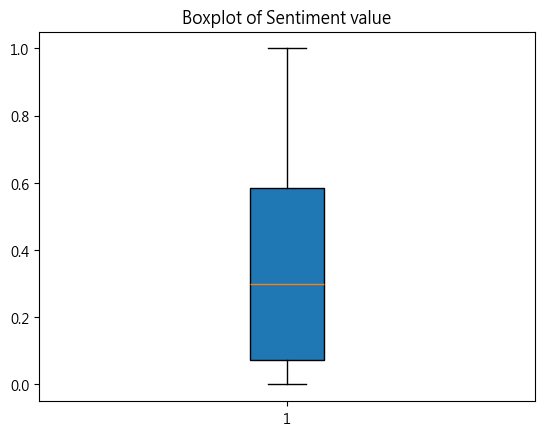

In [78]:
boxplot = plt.boxplot(sentiment_date['sentimentValue'], patch_artist=True)

plt.title('Boxplot of Sentiment value')
plt.show()

- 每日的情緒分數趨勢

In [79]:
sentiment_date['time'] = pd.to_datetime(sentiment_date['time']).dt.date
sentiment_of_date =sentiment_date.groupby(['time'])['sentimentValue'].mean().reset_index()
sentiment_of_date

time  sentimentValue
0    2023-08-01        0.459411
1    2023-08-02        0.408992
2    2023-08-03        0.326180
3    2023-08-05        0.434378
4    2023-08-06        0.272359
..          ...             ...
645  2025-08-30        0.343279
646  2025-08-31        0.307837
647  2025-09-01        0.353723
648  2025-09-02        0.357783
649  2025-09-03        0.348143

[650 rows x 2 columns]

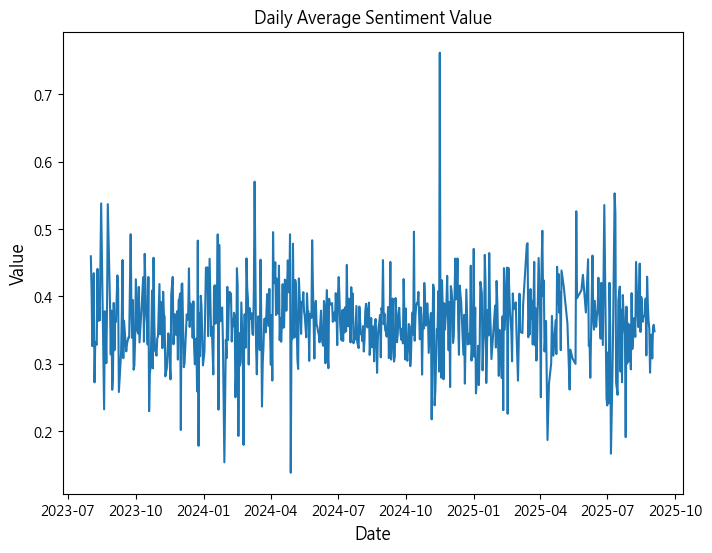

In [80]:
plt.figure(figsize = (8,6))
plt.plot(sentiment_of_date['time'], sentiment_of_date['sentimentValue'],linestyle = '-')
plt.title('Daily Average Sentiment Value')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Value',fontsize = 12)
plt.show()

### 5. TF-IDF

In [81]:
article = pd.read_csv('./filter/article_token.csv')
article

Unnamed: 0                     title  \
0                0                 [請益] 房貸選擇   
1                1                 [請益] 房貸選擇   
2                2                 [請益] 房貸選擇   
3                3                 [請益] 房貸選擇   
4                5                 [請益] 房貸選擇   
...            ...                       ...   
610202     1106247  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610203     1106248  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610204     1106250  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610205     1106252  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610206     1106253  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   

                                                      url  \
0       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                   ...   
610202  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610203  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610204  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610205  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610206  https://www.ptt.cc/bbs/home-sale/M.1692768622....   

                                                  content        date  \
0       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
4       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                   ...         ...   
610202  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610203  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610204  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610205  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610206  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   

                                           filter_content word  
0       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   貸款  
1       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   選擇  
2       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   請益  
3       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行  
4       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安  
...                                                   ...  ...  
610202  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...  申貸者  
610203  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   是否  
610204  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   自住  
610205  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   剛性  
610206  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   需求  

[610207 rows x 7 columns]

In [82]:
# 計算每個詞在每篇文章出現的次數
word_count = article.groupby(['url','word'], as_index=False).size()
word_count.rename(columns={'size':'count'}, inplace=True)

In [83]:
word_count

url  word  count
0       https://www.ptt.cc/bbs/home-sale/M.1692768622....  一千萬元      2
1       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一圓      1
2       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一年      1
3       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一段      1
4       https://www.ptt.cc/bbs/home-sale/M.1692768622....  一萬多元      1
...                                                   ...   ...    ...
427775  https://www.ptt.cc/bbs/home-sale/M.1756887702....    隨便      1
427776  https://www.ptt.cc/bbs/home-sale/M.1756887702....    首購      1
427777  https://www.ptt.cc/bbs/home-sale/M.1756887702....    高達      1
427778  https://www.ptt.cc/bbs/home-sale/M.1756887702....    鬆綁      1
427779  https://www.ptt.cc/bbs/home-sale/M.1756887702....    麻煩      1

[427780 rows x 3 columns]

In [84]:
# 計算每篇文章的詞數
total_words = article.groupby(['url'], as_index=False).size()
total_words.rename(columns={'size':'total'}, inplace = True)

In [85]:
total_words

url  total
0     https://www.ptt.cc/bbs/home-sale/M.1692768622....    186
1     https://www.ptt.cc/bbs/home-sale/M.1692847742....    130
2     https://www.ptt.cc/bbs/home-sale/M.1693109827....    145
3     https://www.ptt.cc/bbs/home-sale/M.1693124773....     75
4     https://www.ptt.cc/bbs/home-sale/M.1693144551....    248
...                                                 ...    ...
3048  https://www.ptt.cc/bbs/home-sale/M.1756827676....    346
3049  https://www.ptt.cc/bbs/home-sale/M.1756870456....     29
3050  https://www.ptt.cc/bbs/home-sale/M.1756870821....    224
3051  https://www.ptt.cc/bbs/home-sale/M.1756877717....     23
3052  https://www.ptt.cc/bbs/home-sale/M.1756887702....    119

[3053 rows x 2 columns]

In [86]:
loan_word = word_count.merge(total_words, on='url', how='left')
loan_word

url  word  count  total
0       https://www.ptt.cc/bbs/home-sale/M.1692768622....  一千萬元      2    186
1       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一圓      1    186
2       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一年      1    186
3       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一段      1    186
4       https://www.ptt.cc/bbs/home-sale/M.1692768622....  一萬多元      1    186
...                                                   ...   ...    ...    ...
427775  https://www.ptt.cc/bbs/home-sale/M.1756887702....    隨便      1    119
427776  https://www.ptt.cc/bbs/home-sale/M.1756887702....    首購      1    119
427777  https://www.ptt.cc/bbs/home-sale/M.1756887702....    高達      1    119
427778  https://www.ptt.cc/bbs/home-sale/M.1756887702....    鬆綁      1    119
427779  https://www.ptt.cc/bbs/home-sale/M.1756887702....    麻煩      1    119

[427780 rows x 4 columns]

- tf(term frequency):某個詞在某一個文件中出現的頻率 -> 詞在該文件出現次數/該文件的詞總數
- idf(inverse document frequent):log(文件數除以某特定詞彙有被多少文件所提及的數量) ->log(總文件數量/包含該詞的文件數量)


In [87]:
# tf 
loan_word_tf_idf = loan_word.assign(tf = loan_word.iloc[:, 2]/loan_word.iloc[:,3])

In [88]:
# 計算每個詞彙出現在幾篇文章中
idf_df = loan_word.groupby(['word'], as_index=False).size()
loan_word_tf_idf = loan_word_tf_idf.merge(idf_df, on='word',how='left')

In [89]:
# 計算idf
loan_word_tf_idf = loan_word_tf_idf.assign(idf = loan_word_tf_idf.iloc[:,5]
                                           .apply(lambda x : math.log((len(total_words)/x),10)))
loan_word_tf_idf = loan_word_tf_idf.drop(labels=['size'],axis = 1)

In [90]:
# 計算tf-idf
loan_word_tf_idf = loan_word_tf_idf.assign(tf_idf = loan_word_tf_idf.iloc[:,4]*loan_word_tf_idf.iloc[:,5])

In [91]:
loan_word_tf_idf

url  word  count  total  \
0       https://www.ptt.cc/bbs/home-sale/M.1692768622....  一千萬元      2    186   
1       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一圓      1    186   
2       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一年      1    186   
3       https://www.ptt.cc/bbs/home-sale/M.1692768622....    一段      1    186   
4       https://www.ptt.cc/bbs/home-sale/M.1692768622....  一萬多元      1    186   
...                                                   ...   ...    ...    ...   
427775  https://www.ptt.cc/bbs/home-sale/M.1756887702....    隨便      1    119   
427776  https://www.ptt.cc/bbs/home-sale/M.1756887702....    首購      1    119   
427777  https://www.ptt.cc/bbs/home-sale/M.1756887702....    高達      1    119   
427778  https://www.ptt.cc/bbs/home-sale/M.1756887702....    鬆綁      1    119   
427779  https://www.ptt.cc/bbs/home-sale/M.1756887702....    麻煩      1    119   

              tf       idf    tf_idf  
0       0.010753  2.443334  0.026272  
1       0.005376  2.405546  0.012933  
2       0.005376  0.835392  0.004491  
3       0.005376  1.565649  0.008417  
4       0.005376  3.183697  0.017117  
...          ...       ...       ...  
427775  0.008403  1.297206  0.010901  
427776  0.008403  0.558384  0.004692  
427777  0.008403  1.314465  0.011046  
427778  0.008403  1.760451  0.014794  
427779  0.008403  1.354393  0.011381  

[427780 rows x 7 columns]

#### 5.1 每篇文章tf-idf值最大的五個詞 

In [92]:
group = loan_word_tf_idf.groupby('url').apply(lambda x : x.nlargest(5, 'tf_idf'))

In [93]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
url                                                                   
https://www.ptt.cc/bbs/home-sale/M.1692768622.A... 22     傳用  0.037470
                                                   117    變調  0.034233
                                                   51     套利  0.029698
                                                   53     小資  0.029088
                                                   0    一千萬元  0.026272
https://www.ptt.cc/bbs/home-sale/M.1692847742.A... 183    繳年  0.105259
                                                   170    方案  0.097552
                                                   172    月繳  0.054168
                                                   140    三年  0.036691
                                                   194    重新  0.034064
https://www.ptt.cc/bbs/home-sale/M.1693109827.A... 223    協助  0.027568
                                                   287    負擔  0.024260
                                                   267    減輕  0.023152
                                                   279    自有  0.022878
                                                   263    民眾  0.022753

#### 5.2 整個文集中tf-idf值高的詞

In [94]:
# 從每篇文章挑選出tf-idf最大的十個詞
(loan_word_tf_idf.groupby("url").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

word  size
11923   萬元    74
2021    億元    66
4812    央行    61
5338   寬限期    56
12172   行庫    55
6923    房貸    49
14219   銀行    49
14804   預售    49
12265   補貼    47
1099    五年    46

In [95]:
article

Unnamed: 0                     title  \
0                0                 [請益] 房貸選擇   
1                1                 [請益] 房貸選擇   
2                2                 [請益] 房貸選擇   
3                3                 [請益] 房貸選擇   
4                5                 [請益] 房貸選擇   
...            ...                       ...   
610202     1106247  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610203     1106248  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610204     1106250  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610205     1106252  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
610206     1106253  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   

                                                      url  \
0       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                   ...   
610202  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610203  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610204  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610205  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
610206  https://www.ptt.cc/bbs/home-sale/M.1692768622....   

                                                  content        date  \
0       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
4       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                   ...         ...   
610202  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610203  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610204  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610205  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
610206  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   

                                           filter_content word  
0       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   貸款  
1       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   選擇  
2       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   請益  
3       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行  
4       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安  
...                                                   ...  ...  
610202  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...  申貸者  
610203  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   是否  
610204  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   自住  
610205  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   剛性  
610206  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   需求  

[610207 rows x 7 columns]

### 6. 透過結巴斷詞與N-gram幫助建立字典

#### 6.1 Bigram

In [96]:
article_token

title  \
0                                   [請益] 房貸選擇   
1                                   [請益] 房貸選擇   
2                                   [請益] 房貸選擇   
3                                   [請益] 房貸選擇   
5                                   [請益] 房貸選擇   
...                                       ...   
1120525  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120527  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120528  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120530  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
1120532  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                       url  \
0        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
5        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                    ...   
1120525  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120527  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120528  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120530  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
1120532  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                   content        date  \
0        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
5        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                    ...         ...   
1120525  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120527  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120528  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120530  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
1120532  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                            filter_content word  
0        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   貸款  
1        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   選擇  
2        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   請益  
3        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行  
5        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安  
...                                                    ...  ...  
1120525  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   啟動  
1120527  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   還沒  
1120528  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   上車  
1120530  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   乘客  
1120532  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...   盡快  

[618162 rows x 6 columns]

In [97]:
loan_bigram = article_token.copy()
loan_bigram = loan_bigram.drop(columns='word').drop_duplicates(subset=['filter_content']) # 先移除原本word的斷詞結果，再跑bigram
loan_bigram

title  \
0                                   [請益] 房貸選擇   
57                     [新聞] 全台房價 自歷史高點回落0.59％   
387                     [請益] 關於內政部的自購住宅貸款利息補貼   
432              Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎   
671              Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭   
...                                       ...   
1118226              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上   
1118642             Re: [閒聊] 85年次以後的年輕工程師有多慘？   
1119550          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊   
1119947               [新聞] 新青安房貸今上路 建商救命浮木來了？   
1120277  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                       url  \
0        https://www.ptt.cc/bbs/home-sale/M.1756870456....   
57       https://www.ptt.cc/bbs/home-sale/M.1756870821....   
387      https://www.ptt.cc/bbs/home-sale/M.1756877717....   
432      https://www.ptt.cc/bbs/home-sale/M.1756887702....   
671      https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                    ...   
1118226  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
1118642  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
1119550  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
1119947  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
1120277  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                   content        date  \
0        貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
57       全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03   
387      爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  2025-09-03   
432      鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  2025-09-03   
671      : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  2025-09-02   
...                                                    ...         ...   
1118226  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  2023-08-01   
1118642  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  2023-08-02   
1119550  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  2023-08-02   
1119947  連結：\nhttps://money.udn.com/money/story/5621/73...  2023-08-01   
1120277  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                            filter_content  
0        貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  
57       全台房價自歷史高點回落郭及天台北報導年月日週一上午去年月日央行第七波選擇性信用管制出爐成為這...  
387      爬了許多文還是不太了解希望有大大能幫忙解答這麼說好了目前我已經有申請新青安年寬限期貸款是萬利...  
432      鬆綁怎麼就只鬆管制部份你要回歸市場機制就要完全回歸新青安就不用講什麼首購最大這種鳥觀念也都要...  
671      連結金管會央行邀銀行研議開大房貸水龍頭內文民眾想買房卻貸不到款卓揆日前喊話希望銀行放款水龍頭...  
...                                                    ...  
1118226  減輕年輕人買房負擔青安貸款升級版今上路賴清德一張圖報你知連結內文記者盧素梅台北報導青年安心成...  
1118642  原文恕刪背景交代一下小弟正好年次前年台大非電資科系碩班畢業上山非產線常日班目前年資剛好兩年家...  
1119550  作者奶奶看板標題新聞新青安貸款威力開始了網曝新北預售屋齊時間媒體來源記者署名余奕賢完整新聞標...  
1119947  連結內文經濟日報記者游智文即時報導新版青年安心成家優惠房貸專案今日上路元宏不動產加值服務平台...  
1120277  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...  

[3094 rows x 5 columns]

In [98]:
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [99]:
tqdm.pandas()

loan_bigram['bigram'] = loan_bigram['filter_content'].swifter.set_dask_threshold(0).progress_bar(enable = True).apply(bigram_getToken)

Pandas Apply: 100%|██████████| 3094/3094 [00:27<00:00, 112.25it/s]


In [100]:
loan_bigram = loan_bigram.explode('bigram').reset_index(drop=True)
loan_bigram

title  \
0                                  [請益] 房貸選擇   
1                                  [請益] 房貸選擇   
2                                  [請益] 房貸選擇   
3                                  [請益] 房貸選擇   
4                                  [請益] 房貸選擇   
...                                      ...   
615063  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
615064  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
615065  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
615066  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
615067  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                      url  \
0       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                   ...   
615063  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
615064  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
615065  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
615066  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
615067  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                  content        date  \
0       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
4       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                   ...         ...   
615063  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
615064  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
615065  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
615066  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
615067  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                           filter_content   bigram  
0       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    貸款 選擇  
1       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    選擇 請益  
2       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    請益 銀行  
3       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行 新青安  
4       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安 寬限期  
...                                                   ...      ...  
615063  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    再次 啟動  
615064  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    啟動 還沒  
615065  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    還沒 上車  
615066  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    上車 乘客  
615067  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    乘客 盡快  

[615068 rows x 6 columns]

##### 統計最常出現的bigram組合

In [101]:
bigram_word = loan_bigram.groupby(['bigram'], as_index= False).size()

In [102]:
# 清除包含英文或數字的bigram組合
wb_filter = list(bigram_word['bigram'].apply(lambda x : True if not re.search("[0-9a-zA-Z]",x) else False))
bigram_word[wb_filter].sort_values(by=['size'], ascending=False)

bigram  size
193571  新青安 房貸   455
341067   連結 內文   453
320614   貸款 成數   325
43433    信用 管制   315
193683  新青安 政策   293
...        ...   ...
380190  龜苓膏 選擇     1
58421    再生 一家     1
58422    再生 一胎     1
380193   龜頭 脫皮     1
380194   龜龜 毛毛     1

[380195 rows x 2 columns]

#### 6.2 Trigram

In [103]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [108]:
loan_trigram = article.copy()
loan_trigram = loan_trigram.drop(columns='word').drop_duplicates(subset=['filter_content']) # 先移除原本word的斷詞結果，再跑trigram
loan_trigram['trigram'] = loan_trigram['filter_content'].swifter.set_dask_threshold(0).progress_bar(enable = True).apply(trigram_getToken)

Pandas Apply: 100%|██████████| 3053/3053 [00:24<00:00, 125.96it/s]


In [109]:
loan_trigram = loan_trigram.explode('trigram').reset_index(drop=True)
loan_trigram

Unnamed: 0                     title  \
0                0                 [請益] 房貸選擇   
1                0                 [請益] 房貸選擇   
2                0                 [請益] 房貸選擇   
3                0                 [請益] 房貸選擇   
4                0                 [請益] 房貸選擇   
...            ...                       ...   
603988     1105982  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
603989     1105982  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
603990     1105982  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
603991     1105982  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   
603992     1105982  Fw: [新聞] 新青安貸款變調 傳用寬限期套利   

                                                      url  \
0       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
2       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
3       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
4       https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                   ...   
603988  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
603989  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
603990  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
603991  https://www.ptt.cc/bbs/home-sale/M.1692768622....   
603992  https://www.ptt.cc/bbs/home-sale/M.1692768622....   

                                                  content        date  \
0       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
2       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
3       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
4       貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                   ...         ...   
603988  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
603989  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
603990  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
603991  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   
603992  作者: semih (Sayginer) 看板: Gossiping\n標題: [新聞] 新...  2023-08-23   

                                           filter_content     trigram  
0       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    貸款 選擇 請益  
1       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    選擇 請益 銀行  
2       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   請益 銀行 新青安  
3       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  銀行 新青安 寬限期  
4       貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安 寬限期 壽險  
...                                                   ...         ...  
603988  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   三千元 月薪 不到  
603989  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...    月薪 不到 五萬  
603990  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...    不到 五萬 貸款  
603991  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...    五萬 貸款 根本  
603992  作者看板標題新聞新青安貸款變調傳用寬限期套利時間聯合報記者朱漢崙台北報導新青安貸款變調傳用寬...   貸款 根本 吃不消  

[603993 rows x 7 columns]

##### 統計最常出現的trigram組合

In [110]:
trigram_word = loan_trigram.groupby(['trigram'], as_index= False).size()

In [111]:
wb_filter = list(trigram_word['trigram'].apply(lambda x : True if not re.search("[0-9a-zA-Z]",x) else False))
trigram_word[wb_filter].sort_values(by=['size'], ascending=False).head(10)

trigram  size
401180    買賣 移轉 棟數    89
45341    企研室 專案 經理    74
148363   專案 經理 曾敬德    74
19683   不動產 企研室 專案    71
100318    台灣 房屋 集團    71
339510    第七 信用 管制    69
199592  房屋 不動產 企研室    69
53297    信義 房屋 不動產    69
98262     台北 即時 報導    68
200213    房屋 集團 趨勢    66

- 從Bigram、Trigram的結果發現，有些詞可以被組合在一起，所以可進一步更新原本自定義的字典

#### 6.3 建立Ngram預測模型

In [12]:
article = pd.read_csv('./raw_data/articles.csv')
article['time'] = pd.to_datetime(article['time'])
article['date'] = article['time'].dt.date
article = article.drop('time',axis=1)

In [13]:
article

title  \
0                                [請益] 房貸選擇   
1                   [新聞] 全台房價 自歷史高點回落0.59％   
2                    [請益] 關於內政部的自購住宅貸款利息補貼   
3             Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎   
4             Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭   
...                                    ...   
3089              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上   
3090             Re: [閒聊] 85年次以後的年輕工程師有多慘？   
3091          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊   
3092               [新聞] 新青安房貸今上路 建商救命浮木來了？   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1     https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2     https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3     https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4     https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                 ...   
3089  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
3090  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
3091  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
3092  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content        date  
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03  
1     全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03  
2     爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  2025-09-03  
3     鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  2025-09-03  
4     : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  2025-09-02  
...                                                 ...         ...  
3089  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  2023-08-01  
3090  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  2023-08-02  
3091  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  2023-08-02  
3092  連結：\nhttps://money.udn.com/money/story/5621/73...  2023-08-01  
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01  

[3094 rows x 4 columns]

In [14]:
# 文章內容正規處理
article['filter_content'] = article.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
article

title  \
0                                [請益] 房貸選擇   
1                   [新聞] 全台房價 自歷史高點回落0.59％   
2                    [請益] 關於內政部的自購住宅貸款利息補貼   
3             Re: [閒聊] 如果把所有房市政策鬆綁取消，台灣會變怎   
4             Re: [新聞] 金管會、央行邀銀行研議 開大房貸水龍頭   
...                                    ...   
3089              [新聞] 減輕年輕人買房負擔！青安貸款升級版今上   
3090             Re: [閒聊] 85年次以後的年輕工程師有多慘？   
3091          Fw: [新聞] 新青安貸款威力開始了?網曝新北預售屋齊   
3092               [新聞] 新青安房貸今上路 建商救命浮木來了？   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
1     https://www.ptt.cc/bbs/home-sale/M.1756870821....   
2     https://www.ptt.cc/bbs/home-sale/M.1756877717....   
3     https://www.ptt.cc/bbs/home-sale/M.1756887702....   
4     https://www.ptt.cc/bbs/home-sale/M.1756804442....   
...                                                 ...   
3089  https://www.ptt.cc/bbs/home-sale/M.1690905091....   
3090  https://www.ptt.cc/bbs/home-sale/M.1690910883....   
3091  https://www.ptt.cc/bbs/home-sale/M.1690938079....   
3092  https://www.ptt.cc/bbs/home-sale/M.1690887173....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content        date  \
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
1     全台房價 自歷史高點回落0.59％\n\n郭及天／台北報導\n2025年9月1日 週一 上午...  2025-09-03   
2     爬了許多文還是不太了解\n希望有大大能幫忙解答\n\n這麼說好了，目前我已經有申請新青安+5...  2025-09-03   
3     鬆綁怎麼就只鬆管制部份？你要回歸市場機制就要完全回歸。\n\n新青安就不用講，什麼首購最大這...  2025-09-03   
4     : 連結：金管會、央行邀銀行研議 開大房貸水龍頭\n:\nhttps://www.ctee....  2025-09-02   
...                                                 ...         ...   
3089  減輕年輕人買房負擔！青安貸款升級版今上路　賴清德一張圖報你知\n\n連結：\nhttps:/...  2023-08-01   
3090  原文恕刪\n背景交代一下\n小弟正好85年次\n前年台大非電資科系碩班畢業\n上山非產線常日...  2023-08-02   
3091  作者: CNS3056 (奶奶) 看板: Gossiping\n標題: [新聞] 新青安貸款...  2023-08-02   
3092  連結：\nhttps://money.udn.com/money/story/5621/73...  2023-08-01   
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                         filter_content  
0     貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  
1     全台房價自歷史高點回落郭及天台北報導年月日週一上午去年月日央行第七波選擇性信用管制出爐成為這...  
2     爬了許多文還是不太了解希望有大大能幫忙解答這麼說好了目前我已經有申請新青安年寬限期貸款是萬利...  
3     鬆綁怎麼就只鬆管制部份你要回歸市場機制就要完全回歸新青安就不用講什麼首購最大這種鳥觀念也都要...  
4     連結金管會央行邀銀行研議開大房貸水龍頭內文民眾想買房卻貸不到款卓揆日前喊話希望銀行放款水龍頭...  
...                                                 ...  
3089  減輕年輕人買房負擔青安貸款升級版今上路賴清德一張圖報你知連結內文記者盧素梅台北報導青年安心成...  
3090  原文恕刪背景交代一下小弟正好年次前年台大非電資科系碩班畢業上山非產線常日班目前年資剛好兩年家...  
3091  作者奶奶看板標題新聞新青安貸款威力開始了網曝新北預售屋齊時間媒體來源記者署名余奕賢完整新聞標...  
3092  連結內文經濟日報記者游智文即時報導新版青年安心成家優惠房貸專案今日上路元宏不動產加值服務平台...  
3093  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...  

[3094 rows x 5 columns]

In [15]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [16]:
sen_tokens = article.filter_content.apply(getToken).tolist()

In [17]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list() # 分子
    words = list() # 分母
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] # P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [18]:
bi_prediction = ngram(sen_tokens, N=2)

In [19]:
text = '新青安'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 房貸, probability: 0.0696
next word: 政策, probability: 0.0448
next word: 寬限期, probability: 0.0226
next word: 首購, probability: 0.0211
next word: 上路, probability: 0.0167


In [20]:
text = '首購'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 新青安, probability: 0.0435
next word: 房貸, probability: 0.0435
next word: 貸款, probability: 0.0301
next word: 自住, probability: 0.0285
next word: 資格, probability: 0.0188


#### 6.4 Bigram視覺化

In [21]:
# 使用FreqDist取得bigram斷詞與出現頻率
bigramfdist = FreqDist()

bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
loan_bigram2 = article.copy()
loan_bigram2['word'] = loan_bigram2.filter_content.apply(bigram_getToken_dict)

In [ ]:
loan_bigram2 = loan_bigram2.explode('word')
loan_bigram2

title  \
0                                [請益] 房貸選擇   
0                                [請益] 房貸選擇   
0                                [請益] 房貸選擇   
0                                [請益] 房貸選擇   
0                                [請益] 房貸選擇   
...                                    ...   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   
3093  Fw: [新聞] 青年購屋貸款8/1新制「加碼」上路　額度最高千萬、年限   

                                                    url  \
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
0     https://www.ptt.cc/bbs/home-sale/M.1756870456....   
...                                                 ...   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   
3093  https://www.ptt.cc/bbs/home-sale/M.1690847681....   

                                                content        date  \
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
0     貸款選擇請益\n\n【A銀行】:\n8成\n新青安\n40年\n2年寬限期\n26萬壽險(不...  2025-09-03   
...                                                 ...         ...   
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   
3093  作者: Ghost325 (Invictus) 看板: Gossiping\n標題: [新聞...  2023-08-01   

                                         filter_content     word  
0     貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    貸款 選擇  
0     貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    選擇 請益  
0     貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...    請益 銀行  
0     貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...   銀行 新青安  
0     貸款選擇請益銀行成新青安年年寬限期萬壽險不可分期銀行成年年寬限期無壽險請問包含壽險部分值得選...  新青安 寬限期  
...                                                 ...      ...  
3093  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    再次 啟動  
3093  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    啟動 還沒  
3093  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    還沒 上車  
3093  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    上車 乘客  
3093  作者看板標題新聞青年購屋貸款新制加碼上路額度最高千萬年限延長面向減壓升級降低買房負擔時間青年...    乘客 盡快  

[615068 rows x 6 columns]

In [ ]:
# 出現次數最多的項目
bigramfdist.most_common(5)

[(('新青安', '房貸'), 455),
 (('連結', '內文'), 453),
 (('貸款', '成數'), 325),
 (('信用', '管制'), 315),
 (('新青安', '政策'), 293)]

In [ ]:
# 建立bigram和count的dictionary
# 取最多的前30項
d = {k:v for k, v in bigramfdist.most_common(35)}

In [ ]:
g = nx.Graph()

# 建立節點之間的連結
for k, v in [d][0].items():
    g.add_edge(k[0], k[1], weight = v)

# 取得edge權重
weights = [w[2]['weight']*0.025 for w in g.edges(data=True)]

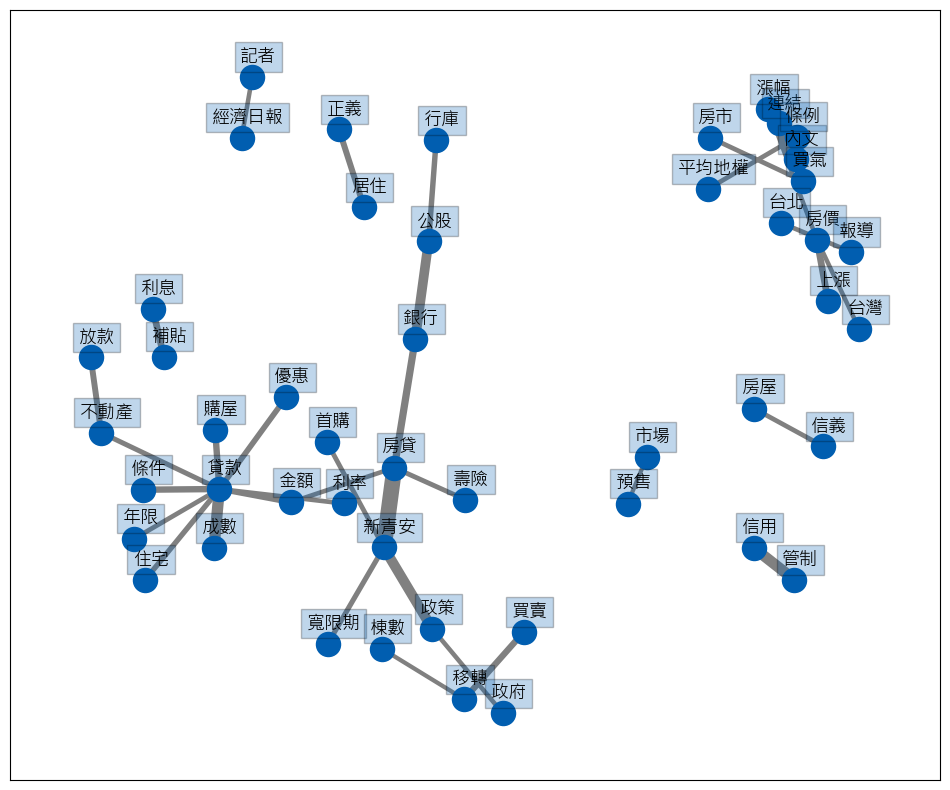

In [ ]:
fig, ax = plt.subplots(figsize = (12, 10))

pos = nx.spring_layout(g, k=2)


# networks
nx.draw_networkx(g, pos,
                 font_size = 16,
                 width = weights,
                 edge_color = 'grey',
                 node_color = '#015eb0',
                 with_labels = False,
                 ax = ax)
# 增加labels
for key, value in pos.items():
    x, y = value[0] + 0.015, value[1]+0.04
    ax.text(x, y,
            s = key,
            bbox = dict(facecolor = '#015eb0', alpha = 0.25),
            horizontalalignment = 'center', fontsize = 13)
    
plt.show()

#### 6.5 Pairwise correlation

In [ ]:
# 取500個最常出現的bigram詞彙
b = {k:v for k, v in bigramfdist.most_common(500)}

In [ ]:
# 建立Df
bigram_df = pd.DataFrame.from_records(
    [(k[0], k[1], v) for k, v in b.items()],
    columns= ['word', 'word1', 'n']
)

In [ ]:
# 再次計算各詞彙在各文章中出現的次數
data = article.copy()
data['word'] = data.filter_content.apply(getToken)
data = data.explode('word')

word_count2 = data.groupby(['url','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)
word_count2.head(3)

url word  count
0  https://www.ptt.cc/bbs/home-sale/M.1690847681....   一件      1
1  https://www.ptt.cc/bbs/home-sale/M.1690847681....   一環      1
2  https://www.ptt.cc/bbs/home-sale/M.1690847681....   上路      2

In [ ]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["url"]))
    tnx = len(article)-nx # 不含x的文章數
    #total y
    ny = len(set(word_count2[word_count2["word"]==df["word1"]]["url"]))
    tny = len(article)-ny # 不含y的文章數
    #有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["url"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word1"]]["url"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(article["url"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [ ]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis = 1)
bigram_df = bigram_df[bigram_df['word']!= bigram_df['word1']]

In [ ]:
bigram_df

word word1    n       cor
0     新青安    房貸  455  0.054687
1      連結    內文  453  0.877142
2      貸款    成數  325  0.268892
3      信用    管制  315  0.553349
4     新青安    政策  293  0.024243
..    ...   ...  ...       ...
495   楞嚴經    大乘   31  1.000000
496    大乘    佛經   31  1.000000
497    佛經  阿彌陀佛   31  0.890391
498  阿彌陀佛   藥師佛   31  0.890391
499   藥師佛    大乘   31  1.000000

[494 rows x 4 columns]

##### 和新青安、首購相關性最高的15個詞

In [ ]:
loan_sum = bigram_df[(bigram_df['word'] == '新青安')].sort_values(by =['cor'], ascending=False).head(15).sort_values(by=['cor'])
nbuy_sum = bigram_df[(bigram_df['word'] == '房價')].sort_values(by =['cor'], ascending=False).head(15).sort_values(by=['cor'])

<BarContainer object of 15 artists>

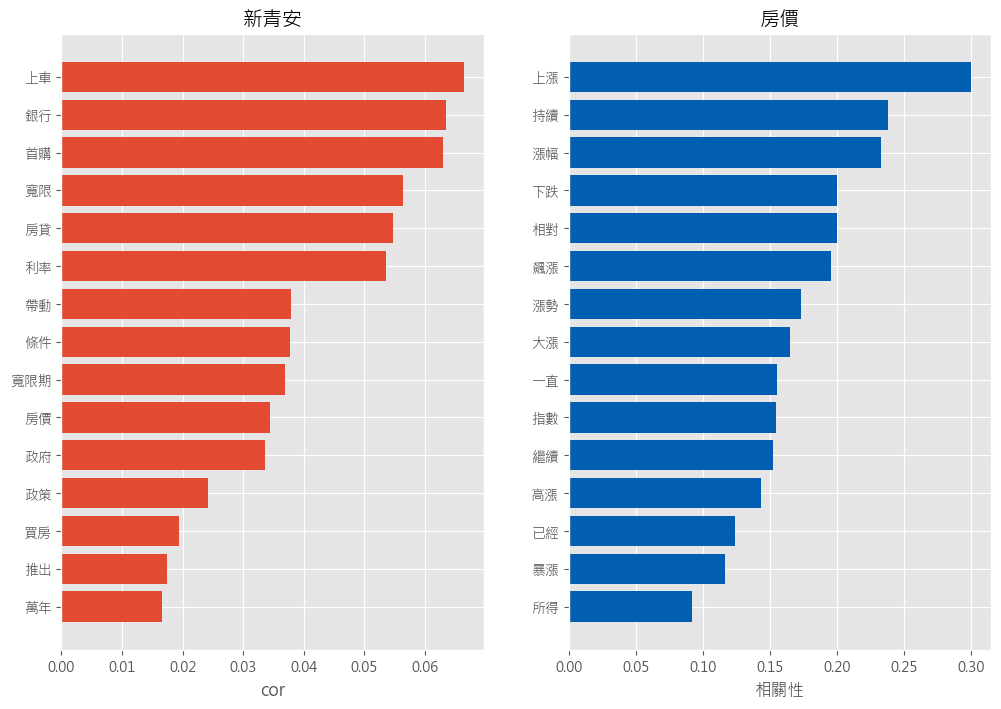

In [ ]:
plt.figure(figsize=(12,8))
plt.style.use("ggplot")

plt.subplot(121)
plt.title('新青安')
plt.xlabel('cor')
plt.barh(loan_sum['word1'], loan_sum['cor'])

plt.subplot(122)
plt.title('房價')
plt.xlabel('相關性')
plt.barh(nbuy_sum['word1'], nbuy_sum['cor'], color = '#015eb0')


#### 6.6 以詞彙關係圖畫出相關性介於0.4-0.6的組合

**備註**  
會選擇0.4-0.6是因為發現>0.8以上的詞彙跟原本沒有太多的相關性，比較多是PTT使用者會說的用詞，並偏向宗教性質。  
所以為了使相關性聚焦於議題的相關用詞，所以將相關性範圍定在0.4-0.6之間

In [ ]:
word_cor =  bigram_df[(bigram_df['cor'] > 0.4) & (bigram_df['cor'] <= 0.6)]
word_cor.reset_index(inplace=True, drop=True)

In [ ]:
word_cor

word word1    n       cor
0         信用    管制  315  0.553349
1         買賣    移轉  181  0.522593
2         公股    行庫  157  0.447503
3         房市    買氣  136  0.409032
4         台北    報導  134  0.416120
5       經濟日報    記者  130  0.473741
6         即時    報導  119  0.467307
7         歷史    新高   99  0.401307
8         生活    機能   96  0.447214
9        銀行法    第條   82  0.572295
10        民眾    購屋   79  0.405674
11        總裁    金龍   79  0.496994
12        八大    行庫   78  0.538354
13        專案    經理   75  0.519924
14       企研室    專案   74  0.584990
15  青年安心成家購屋    優惠   72  0.424069
16        集團    趨勢   68  0.400379
17        台南    高雄   60  0.477075
18        安心    成家   55  0.449213
19        執行    總監   53  0.455563
20        統計    顯示   47  0.411020
21       研究室    執行   47  0.502240
22        購屋    民眾   47  0.405674
23       游智文    即時   43  0.538604
24        強力    過件   40  0.504412
25        表示    房市   40  0.402643
26        內文    記者   39  0.414625
27        走路    分鐘   39  0.479085
28        地緣    政治   38  0.439147
29       台北市    新北   37  0.512545
30        編輯    臺灣   35  0.445956
31        不可    轉載   33  0.433708
32        轉載    媒體   33  0.517740
33        央行    管制   31  0.449495

In [ ]:
g = nx.Graph()

# 建立節點之間的連結
for i in range(len(word_cor)):
    g.add_edge(word_cor["word"][i], word_cor["word1"][i], weight=word_cor["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*2 for w in  g.edges(data=True)]

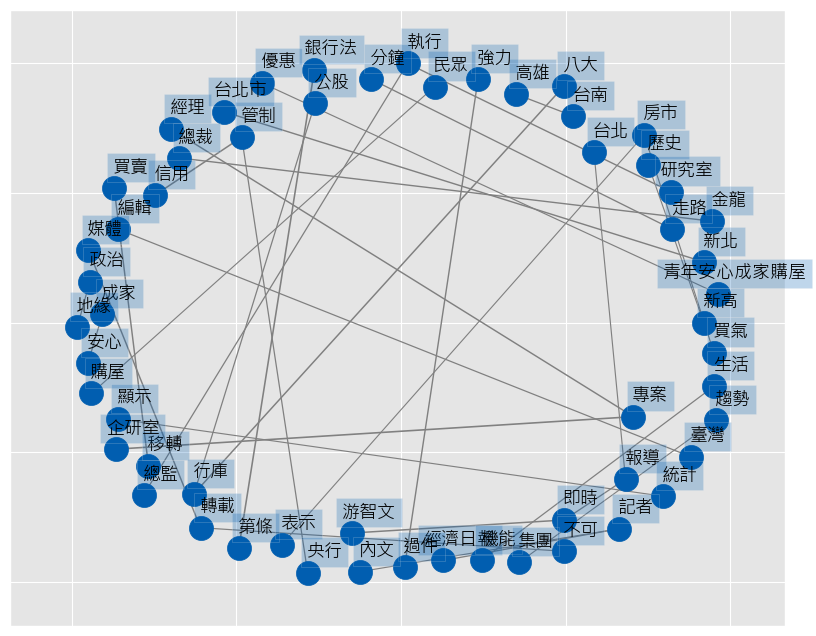

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(g, k=2)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='#015eb0',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+0.051, value[1]+0.06
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='#015eb0', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 7.計算文章相似度

In [ ]:
data_cos = article.copy()
data_cos = data_cos.loc[:,['title','date','url','content','filter_content']]
data_cos['word'] = data_cos.filter_content.apply(getToken).map(' '.join)

KeyboardInterrupt: 

In [ ]:
# bag of word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos['word'])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns=vocabulary, data=X.toarray())
DTM_df.head()

In [ ]:
transformer = TfidfTransformer()

# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns=vocabulary, data=tfidf.toarray())
TFIDF_df.head()

In [ ]:
# 計算cosine-similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i ) / (norm(vector)*norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=['cosine_similarity'])
    return df 

- 找和第一篇文章相似的其他文章

In [ ]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

In [ ]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cosine_similarity","title"]].sort_values(by=['cosine_similarity'], ascending=False).head(10)

cosine_similarity                       title
1              1.000000      [新聞] 全台房價 自歷史高點回落0.59％
2347           0.326371        [新聞] Q1房價奔新高 雙北上演補漲秀
2443           0.298830          [新聞] 四大房價指數 同寫歷史新高
679            0.251557  [新聞] 央行6波信用管制後「房價仍漲53%」　中信
1830           0.250706    [新聞] 房價續飆 第二季政大永慶即時房價指數全
2384           0.245066    [新聞] 房仲：首季房價指數勝去年同期 估全年房
2433           0.243639    [新聞] 新青安讓房價又漲了？四大房價指數創歷史
569            0.242008      [新聞] 好消息？房價開始跌了！兩縣市「老公
2992           0.235076     [新聞] 追不上！房價漲幅是所得漲幅的6.7倍
2488           0.232579      [新聞] 七都價格向上 新竹房價漲82%最猛